In [ ]:
!pip install gap-stat
# !pip

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gap-stat: filename=gap_stat-2.0.3-py3-none-any.whl size=6133 sha256=229a2ae7373f9227c4e7e83a86297e11d3e48a7d2660b9bd0674e6289a38c2d7
  Stored in directory: /root/.cache/pip/wheels/e6/75/de/ee29b366258cdeccdacaff94d895b9d2ffc95a486f3b982441
Successfully built gap-stat


In [ ]:
pip install --downgrade scikit-learn


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --downgrade


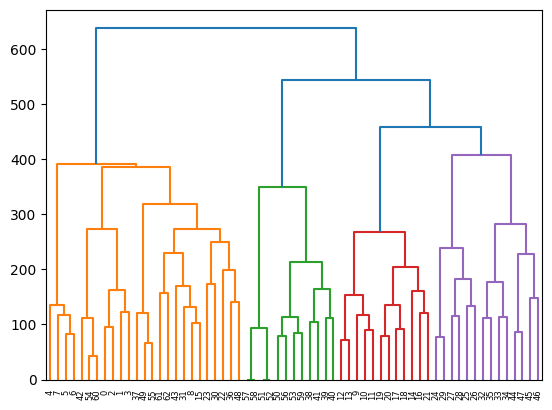

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


cluster labels are :
[1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 1 3 3 3 3 3 3 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1
 1 2 2 2 2 1 1 0 0 0 0 1 1 2 2 2 2 1 1 2 2 2 2 1 1 1]


In [ ]:
# imports
import logging as log
import os
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.cluster as cluster
import sklearn.preprocessing as pre
from gap_statistic import OptimalK
from scipy.cluster import hierarchy
from scipy.stats import mode
from sklearn.impute import SimpleImputer

# get variables
'''
data_path = str(sys.argv[1])
time = float(sys.argv[2])
process_type = sys.argv[3] if len(sys.argv) > 3 else 'none'
'''
data_path = '/content/'
time = 0.5
num_features = 4
time_percent = int(100 * time)

# logger
prefix = datetime.now().strftime('%Y%m%d_%H%M%S')
log_name = prefix + '_clustering_select_best_' + str(time_percent)


import sys

log.basicConfig(stream=sys.stdout, level=log.INFO, format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

log.basicConfig(filename=os.path.join(data_path,  log_name + '.log'), filemode='w', level=log.INFO,
                format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

# ------------------ read data -----------------------
data = pd.read_csv(os.path.join(data_path,  'input_' + str(time_percent) + '.csv'), sep='#')
data.drop(data.columns[0], axis=1, inplace=True)
# print ("data head is ")

ids = data['UID']
course = data['COURSE']
target = data['TARGET']

# get labels (y) and dataset (df)
data.drop('UID', axis=1, inplace=True, errors='ignore')
data.drop('COURSE', axis=1, inplace=True, errors='ignore')
data.drop('TARGET', axis=1, inplace=True, errors='ignore')
data.drop('NP_TARGET', axis=1, inplace=True, errors='ignore')
data.drop('ALL_GRADES_PAST', axis=1, inplace=True, errors='ignore')
data.drop('NP_ACCOMPLISH_MANDATORY_GRADE', axis=1, inplace=True, errors='ignore')
data.drop('NP_ACCOMPLISH_OPTIONAL_GRADE', axis=1, inplace=True, errors='ignore')
log.info('Original shape {}'.format(data.shape))

# ------------------- change -1 values by mean -------------------

cols = data.columns

data = data.replace(-1, np.nan)
data = data.replace(-1.0, np.nan)
# print(data.head)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_without_null = imp.fit_transform(data)
pickle.dump(imp, open(os.path.join(data_path,  str(time_percent) + '_imputer.pkl'), 'wb'))

scaler = pre.StandardScaler()
scaled_data = scaler.fit_transform(df_without_null)
pickle.dump(scaler, open(os.path.join(data_path, str(time_percent) + '_scaler.pkl'), 'wb'))
data = pd.DataFrame(scaled_data, columns=cols)

Z = hierarchy.linkage(np.transpose(scaled_data), 'ward')
plt.figure()
dn = hierarchy.dendrogram(Z)
plt.show()

cluster_process = cluster.FeatureAgglomeration(n_clusters=num_features, affinity='euclidean', linkage='ward')
data_agg = cluster_process.fit_transform(data)
pickle.dump(cluster_process, open(os.path.join(data_path,  str(time_percent) + '_aggregator.pkl'), 'wb'))

log.info(cluster_process.labels_)
print("cluster labels are :")
print(cluster_process.labels_)

for i in range(num_features):
    log.info(' '.join(cols[cluster_process.labels_ == i]))

# num_clusters_list = []
# for i in range(1, 100):
#     optimalK = OptimalK()
#     try:
#         num_clusters_list.append(optimalK(data_agg, cluster_array=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))
#     except:
#         num_clusters_list.append(0)

# print("num_clusters_list are :")
# print(num_clusters_list)
# num_cluster = mode(num_clusters_list)[0]
# print('Number of clusters = {}'.format(num_cluster))
# log.info('Number of clusters = {}'.format(num_cluster))

cluster_data_process = cluster.KMeans(n_clusters=6, init='k-means++', tol=0.0001, algorithm='auto',
                                      n_init=200)

data2 = cluster_data_process.fit_predict(data_agg)
pickle.dump(cluster_data_process, open(os.path.join(data_path,  str(time_percent) + '_cluster.pkl'), 'wb'))

log.info('Unique clusters {}'.format(np.unique(data2)))
log.info('Centroids {}'.format(cluster_data_process.cluster_centers_))

new_cols = []
for i in range(num_features):
    new_cols.append('var' + str(i))

X = pd.DataFrame(data_agg, columns=new_cols)

X.loc[:, 'UID'] = pd.Series(ids, index=X.index)
X.loc[:, 'COURSE'] = pd.Series(course, index=X.index)
X.loc[:, 'TARGET'] = pd.Series(target, index=X.index)
X.loc[:, 'CLUSTER'] = pd.Series(data2, index=X.index)

X.to_pickle(os.path.join(data_path,  'output_agg_simple_' + str(time_percent) + '.pkl'))

data.loc[:, 'UID'] = pd.Series(ids, index=data.index)
data.loc[:, 'COURSE'] = pd.Series(course, index=data.index)
data.loc[:, 'TARGET'] = pd.Series(target, index=data.index)
data.loc[:, 'CLUSTER'] = pd.Series(data2, index=data.index)

data.to_pickle(os.path.join(data_path,  'output_agg_all_' + str(time_percent) + '.pkl'))

In [ ]:
explained_variance_ratio = cluster.explained_variance_ratio_
print("Explained Variance Ratio:")
print(explained_variance_ratio)


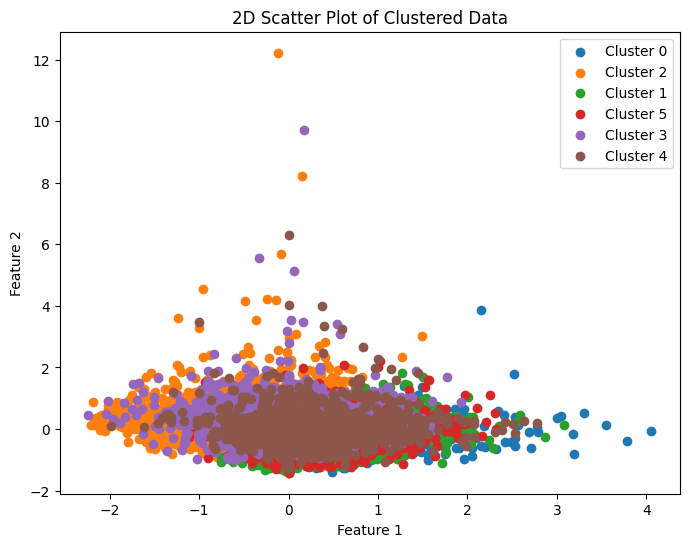

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the clustered data
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

# Plotting the 2D graph
plt.figure(figsize=(8, 6))
for cluster_label in clustered_data['CLUSTER'].unique():
    cluster_points = clustered_data[clustered_data['CLUSTER'] == cluster_label]
    plt.scatter(cluster_points['var0'], cluster_points['var1'], label=f'Cluster {cluster_label}')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Scatter Plot of Clustered Data')
plt.legend()
plt.show()


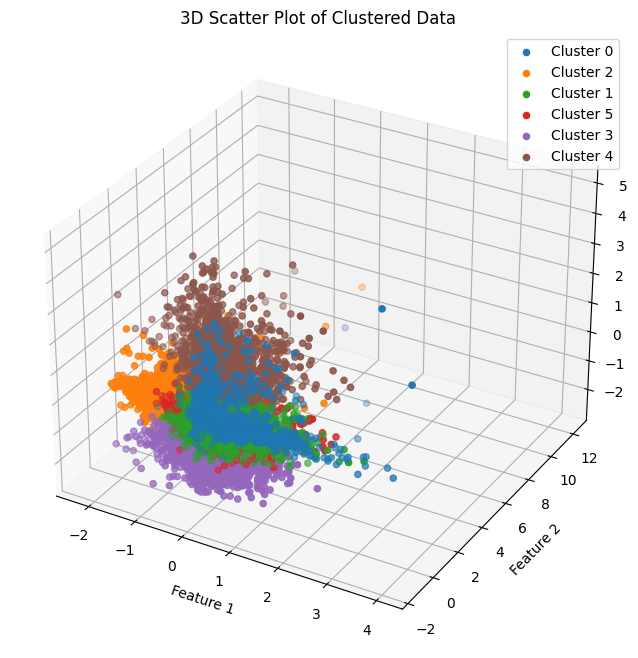

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing this for 3D plotting

# Load the clustered data
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

# Plotting the 3D graph
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster_label in clustered_data['CLUSTER'].unique():
    cluster_points = clustered_data[clustered_data['CLUSTER'] == cluster_label]
    ax.scatter(cluster_points['var0'], cluster_points['var1'], cluster_points['var2'], label=f'Cluster {cluster_label}')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of Clustered Data')
ax.legend()

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the clustered data
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

# Get unique cluster labels
clusters = clustered_data['CLUSTER'].unique()

# Plotting box plots for each feature in each cluster
for cluster_label in clusters:
    cluster_data = clustered_data[clustered_data['CLUSTER'] == cluster_label]

    plt.figure(figsize=(10, 6))
    plt.boxplot([cluster_data['var0'], cluster_data['var1'], cluster_data['var2'], cluster_data['var3']], labels=['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4'])
    plt.title(f'Box Plot for Cluster {cluster_label}')
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the clustered data
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

# Melt the data for Seaborn's boxplot
melted_data = pd.melt(clustered_data, id_vars=['CLUSTER'], var_name='Feature', value_name='Value')

# Plotting the box plot for each cluster with all features differentiated
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

sns.boxplot(x='CLUSTER', y='Value', hue='Feature', data=melted_data, showfliers=False)
plt.title('Box Plot of All Features for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Feature Values')
plt.legend(title='Features')
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the clustered data
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

# Keep only the specified features
features_to_plot = ['var0', 'var1', 'var2', 'var3']
clustered_data_subset = clustered_data[['CLUSTER'] + features_to_plot]

# Melt the data for Seaborn's pointplot
melted_data = pd.melt(clustered_data_subset, id_vars=['CLUSTER'], var_name='Feature', value_name='Performance')

# Calculate mean and confidence intervals
mean_data = melted_data.groupby(['CLUSTER', 'Feature']).mean().reset_index()
ci_data = melted_data.groupby(['CLUSTER', 'Feature']).apply(lambda x: np.percentile(x['Performance'], [2.5, 97.5])).reset_index()
ci_data.columns = ['CLUSTER', 'Feature', 'CI_lower', 'CI_upper']
ci_data['Mean'] = mean_data['Performance']

# Plotting students' performance for each cluster with confidence intervals
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

sns.pointplot(x='CLUSTER', y='Mean', hue='Feature', data=mean_data, dodge=True, markers='o', ci=None)
for i in range(len(ci_data)):
    plt.plot([ci_data.iloc[i]['CLUSTER'], ci_data.iloc[i]['CLUSTER']], [ci_data.iloc[i]['CI_lower'], ci_data.iloc[i]['CI_upper']], color='black', linewidth=1.5)
plt.axhline(y=mean_data['Performance'].mean(), color='r', linestyle='--', label='Mean Performance')

plt.title("Students' Performance for Each Cluster")
plt.xlabel('Cluster')
plt.ylabel("Performance")
plt.legend(title='Features')
plt.show()


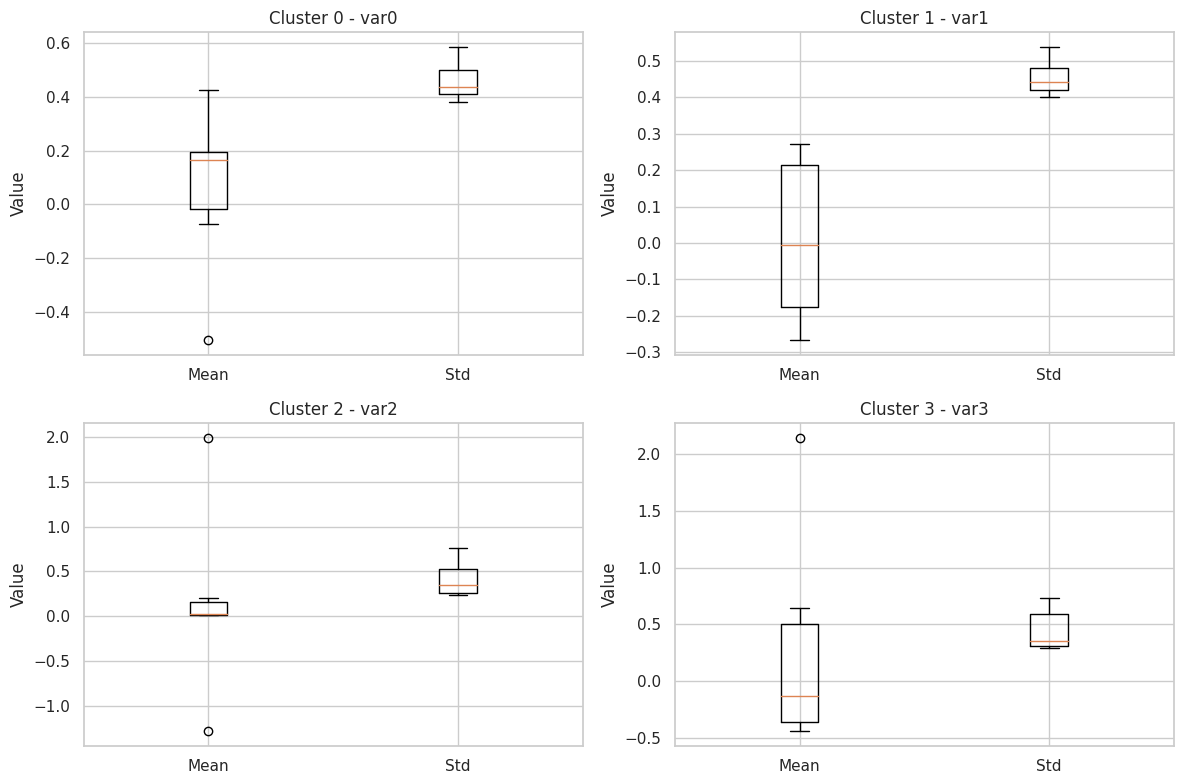

In [ ]:
# Group the data by CLUSTER and calculate the mean and standard deviation for each cluster
cluster_stats = X.groupby('CLUSTER').agg({'var0': ['mean', 'std'], 'var1': ['mean', 'std'], 'var2': ['mean', 'std'], 'var3': ['mean', 'std']})

# Create a box plot for each variable
plt.figure(figsize=(12, 8))
for i, col in enumerate(cluster_stats.columns.levels[0]):
    plt.subplot(2, 2, i + 1)
    data = [cluster_stats[col]['mean'], cluster_stats[col]['std']]
    plt.boxplot(data, labels=['Mean', 'Std'])
    plt.title(f'Cluster {i} - {col}')
    plt.ylabel('Value')
plt.tight_layout()
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the clustered data from pickle file (assuming the filename is based on time window)
time_window = int(100 * 0.5)  # Assuming time is already defined
data = pd.read_pickle(os.path.join(data_path, 'output_agg_all_' + str(time_window) + '.pkl'))

# Assuming the features of interest are named 'var1' to 'var4' based on the script
features_to_plot = ['var1', 'var2', 'var3', 'var4']
num_clusters = data['CLUSTER'].nunique()  # Get the number of unique clusters

# Create a figure for plotting (2 rows for percentages, one for each moment)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
percentages = ['10%', '25%', '33%', '50%']  # Assuming percentages from the image

# Iterate over percentages and moments to plot distributions within clusters
for i in range(2):  # Loop for rows (percentages)
    for j in range(2):  # Loop for moments (left column)
        moment_index = i * 2 + j
        if moment_index >= len(percentages):
            continue  # Skip if exceeding number of moments

        # Filter data for the current moment (assuming 'Moment of Prediction' column exists)
        moment_data = data[data['Moment of Prediction'] == percentages[moment_index]]

        # Plot distribution for each cluster in this moment
        for cluster_label in moment_data['CLUSTER'].unique():
            cluster_points = moment_data[moment_data['CLUSTER'] == cluster_label]
            axes[i, j].hist(cluster_points[features_to_plot[0]], bins=10, alpha=0.5, label=f'C{cluster_label}')  # Adjust alpha for transparency

        axes[i, j].set_xlabel(features_to_plot[0])  # Set labels for the first moment
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_title(f'{percentages[moment_index]} - Moment of Prediction')
        axes[i, j].legend(loc='upper right')

# Plot distribution for all moments (rightmost column)
for k, cluster_label in enumerate(data['CLUSTER'].unique()):
    cluster_data = data[data['CLUSTER'] == cluster_label]
    axes[0, 2].hist(cluster_data[features_to_plot[1]], bins=10, alpha=0.5, label=f'C{cluster_label}')
    axes[1, 2].hist(cluster_data[features_to_plot[2]], bins=10, alpha=0.5, label=f'C{cluster_label}')

# Set labels and title for the rightmost column
axes[0, 2].set_xlabel(features_to_plot[1])
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('All Moments - Average')
axes[1, 2].set_xlabel(features_to_plot[2])
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('All Moments - Average')
axes[1, 2].legend(loc='upper right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


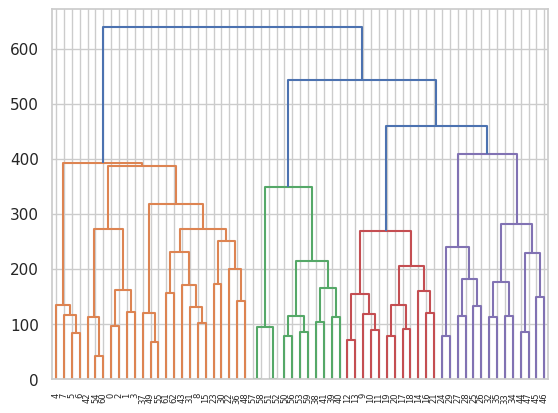

In [ ]:
Z = hierarchy.linkage(np.transpose(scaled_data), 'ward')
plt.figure()
dn = hierarchy.dendrogram(Z)
plt.show()


In [ ]:
# Load the clustered data
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

# Plotting box plots by cluster
plt.figure(figsize=(10, 6))
for feature in ['var0', 'var1', 'var2', 'var3']:
    clustered_data.boxplot(column=feature, by='CLUSTER', figsize=(10, 6))
    plt.title(f'Box Plot of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the clustered data
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

print(clustered_data.head())

# Plotting a single box plot for all four features
plt.figure(figsize=(10, 6))
plt.boxplot([clustered_data['var0'], clustered_data['var1'], clustered_data['var2'], clustered_data['var3']])
plt.title('Box Plot of Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks([1, 2, 3, 4], ['var0', 'var1', 'var2', 'var3'])
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the data from pickle file
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

# Creating box plots for each cluster
plt.figure(figsize=(12, 8))

# Grouping the data by 'CLUSTER' column
grouped_data = clustered_data.groupby('CLUSTER')

# Iterating over each cluster and creating a box plot
for cluster, data in grouped_data:
    plt.subplot(2, 2, cluster + 1)  # Adjust the subplot layout based on the number of clusters
    data.boxplot(column=['var0', 'var1', 'var2', 'var3'])
    plt.title(f'Cluster {cluster}')
    plt.ylabel('Values')
    plt.xlabel('Features')

plt.suptitle('Box Plots for Each Cluster')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Read the data from pickle file
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

# Calculate N (number of students per group)
group_counts = clustered_data.groupby('CLUSTER').size().reset_index(name='N')

# Calculate variable average and standard deviation per cluster for each feature
cluster_stats = clustered_data.groupby('CLUSTER').agg({
    'var0': ['mean', 'std'],
    'var1': ['mean', 'std'],
    'var2': ['mean', 'std'],
    'var3': ['mean', 'std']
})

# Print the results
print("Number of students per group (N):")
print(group_counts)
print("\nVariable average and standard deviation per cluster:")
print(cluster_stats)


Number of students per group (N):
   CLUSTER     N
0        0  1522
1        1  8044
2        2  6056
3        3  3054
4        4  1627
5        5  4957

Variable average and standard deviation per cluster:
             var0                var1                var2                var3  \
             mean       std      mean       std      mean       std      mean   
CLUSTER                                                                         
0        0.426558  0.586282 -0.266320  0.433148  0.199681  0.558934  2.138693   
1        0.197929  0.381560 -0.202663  0.413969  0.011102  0.242425 -0.354215   
2       -0.504954  0.409289  0.256271  0.452320  0.037308  0.266117 -0.437457   
3       -0.071257  0.454507  0.271966  0.487583 -1.279221  0.422125 -0.356694   
4        0.184056  0.518028  0.085935  0.537362  1.987584  0.758392  0.093042   
5        0.148236  0.421596 -0.098207  0.400786  0.010850  0.265405  0.641803   

                   
              std  
CLUSTER            
0  

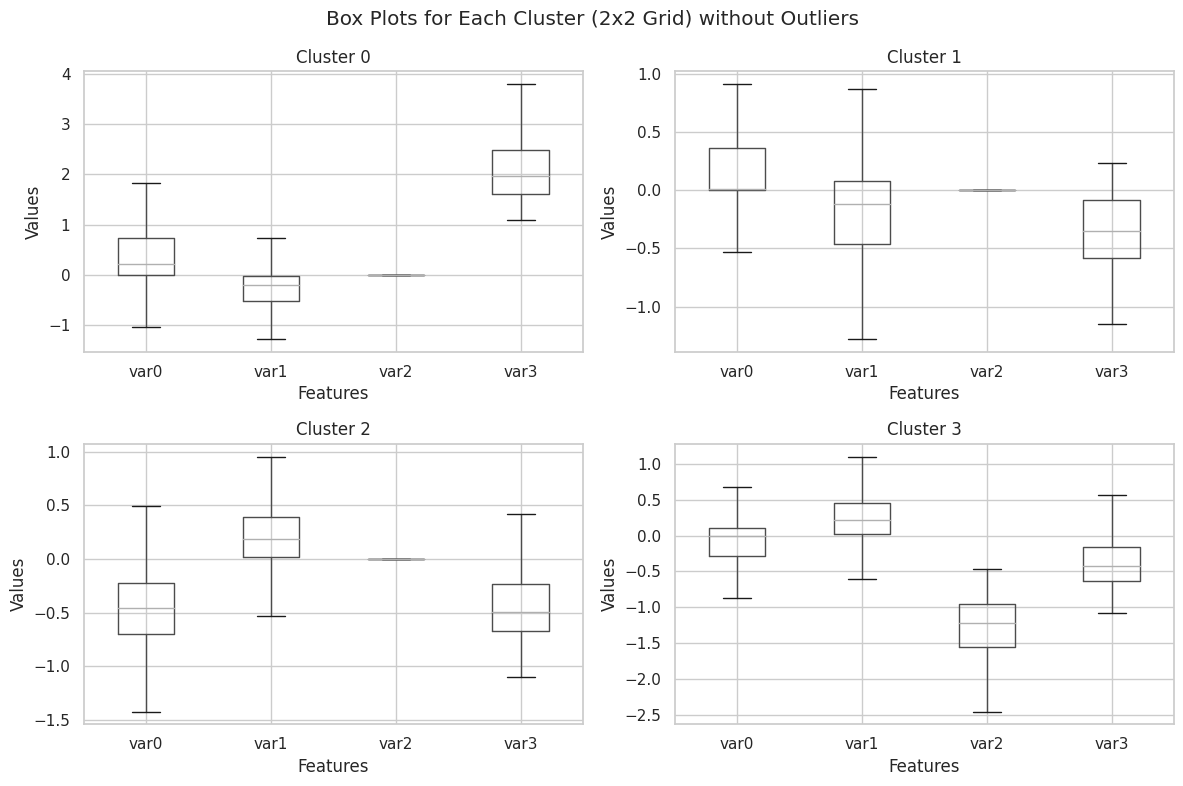

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the data from pickle file
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

# Creating the 2x2 grid of box plots without outliers
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Grouping the data by 'CLUSTER' column
grouped_data = clustered_data.groupby('CLUSTER')

# Iterating over each cluster and creating a box plot in the grid
for cluster, ax in zip(grouped_data.groups.keys(), axs.flatten()):
    cluster_data = grouped_data.get_group(cluster)
    cluster_data.boxplot(column=['var0', 'var1', 'var2', 'var3'], ax=ax, showfliers=False)
    ax.set_title(f'Cluster {cluster}')
    ax.set_ylabel('Values')
    ax.set_xlabel('Features')

# Adjusting layout and displaying the plot
plt.suptitle('Box Plots for Each Cluster (2x2 Grid) without Outliers')
plt.tight_layout()
plt.show()


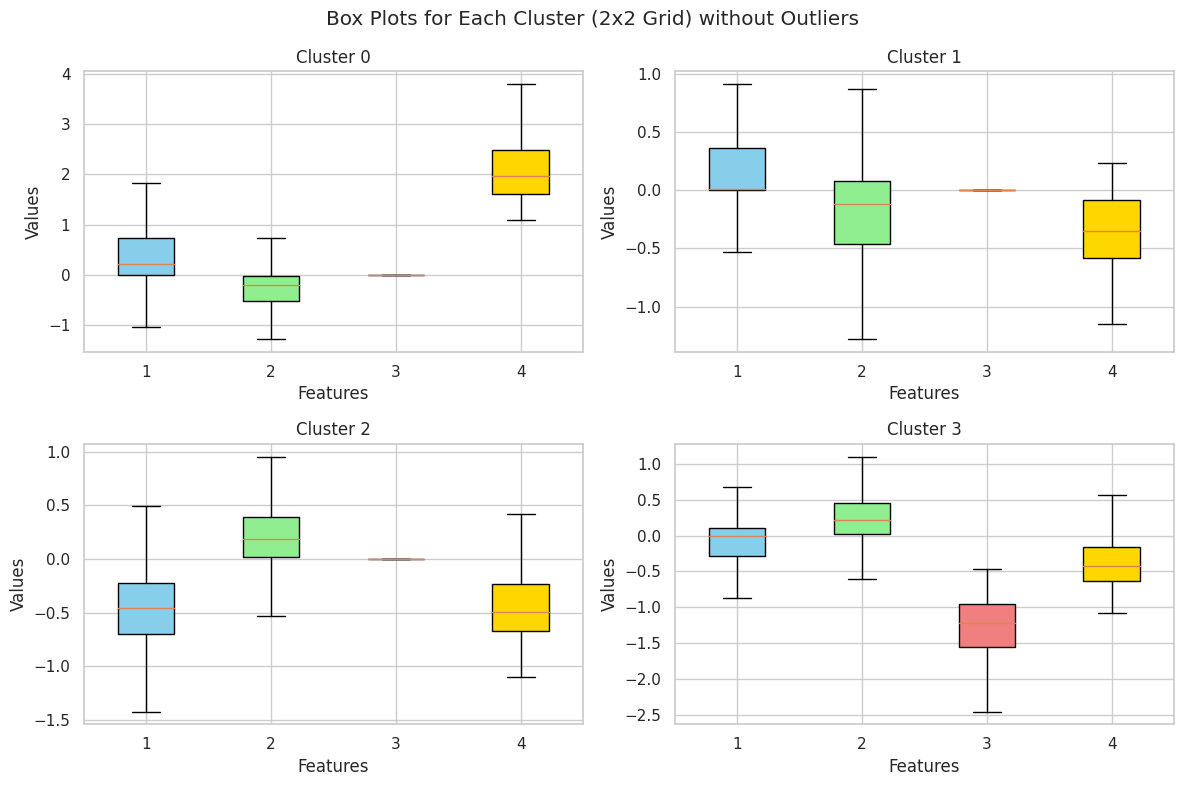

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the data from pickle file
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

# Define colors for each feature
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

# Creating the 2x2 grid of box plots with specified colors
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Grouping the data by 'CLUSTER' column
grouped_data = clustered_data.groupby('CLUSTER')

# Iterating over each cluster and creating a box plot in the grid
for idx, (cluster, ax) in enumerate(zip(grouped_data.groups.keys(), axs.flatten())):
    cluster_data = grouped_data.get_group(cluster)
    bp = ax.boxplot(cluster_data[['var0', 'var1', 'var2', 'var3']], showfliers=False, patch_artist=True)

    # Set colors for each box
    for box, color in zip(bp['boxes'], colors):
        box.set(facecolor=color)  # Set the color of the box

    ax.set_title(f'Cluster {cluster}')
    ax.set_ylabel('Values')
    ax.set_xlabel('Features')

# Adjusting layout and displaying the plot
plt.suptitle('Box Plots for Each Cluster (2x2 Grid) without Outliers')
plt.tight_layout()
plt.show()


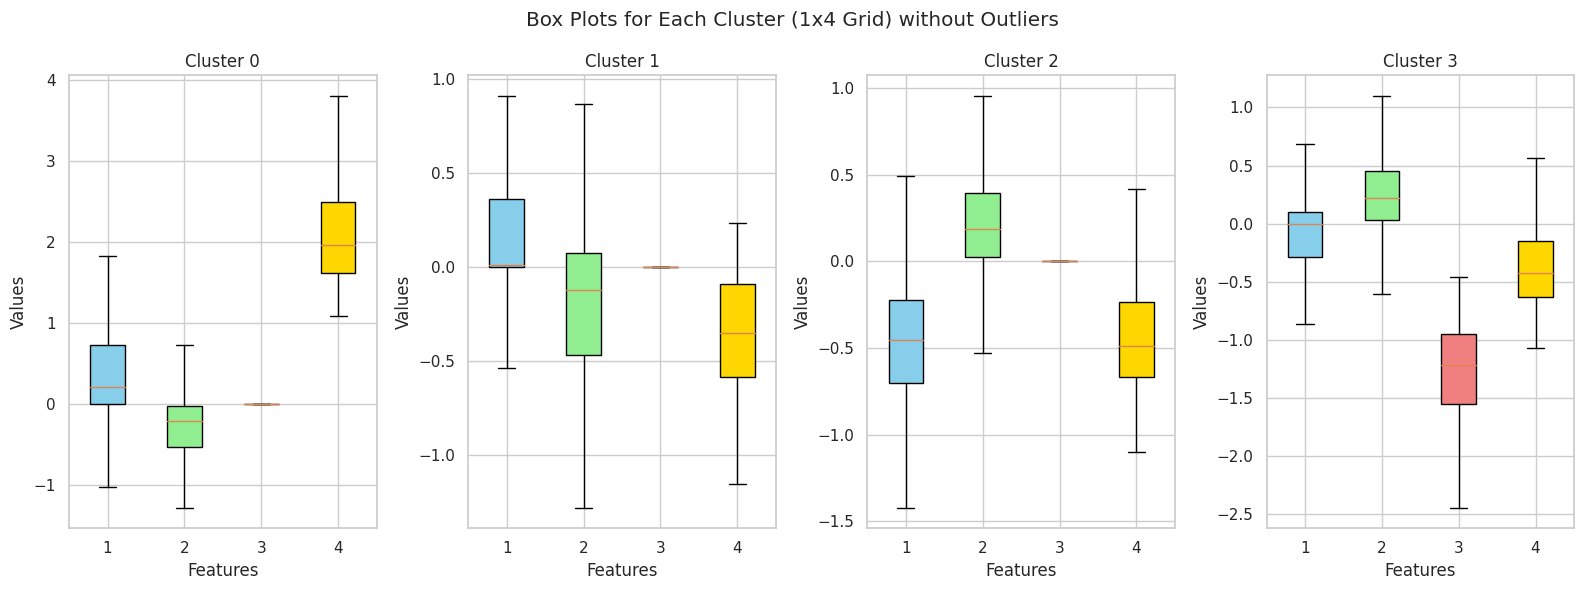

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the data from pickle file
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

# Define colors for each feature
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

# Creating the 1x4 grid of box plots with specified colors
fig, axs = plt.subplots(1, 4, figsize=(16, 6))  # 1 row, 4 columns

# Grouping the data by 'CLUSTER' column
grouped_data = clustered_data.groupby('CLUSTER')

# Iterating over each cluster and creating a box plot in the grid
for idx, (cluster, ax) in enumerate(zip(grouped_data.groups.keys(), axs)):
    cluster_data = grouped_data.get_group(cluster)
    bp = ax.boxplot(cluster_data[['var0', 'var1', 'var2', 'var3']], showfliers=False, patch_artist=True)

    # Set colors for each box
    for box, color in zip(bp['boxes'], colors):
        box.set(facecolor=color)  # Set the color of the box

    ax.set_title(f'Cluster {cluster}')
    ax.set_ylabel('Values')
    ax.set_xlabel('Features')

# Adjusting layout and displaying the plot
plt.suptitle('Box Plots for Each Cluster (1x4 Grid) without Outliers')
plt.tight_layout()
plt.show()


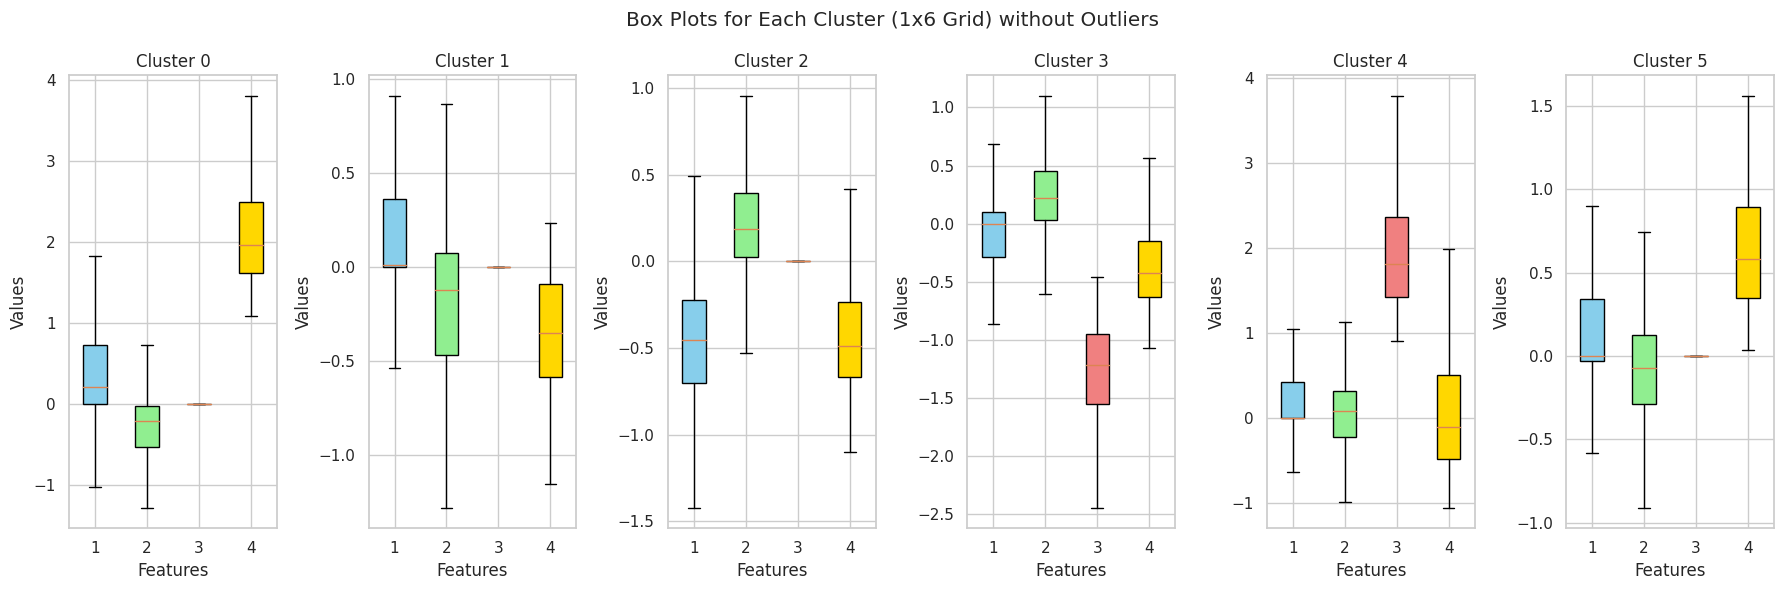

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the data from pickle file
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

# Define colors for each feature
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

# Creating the 1x6 grid of box plots with specified colors
fig, axs = plt.subplots(1, 6, figsize=(18, 6))  # 1 row, 6 columns

# Grouping the data by 'CLUSTER' column
grouped_data = clustered_data.groupby('CLUSTER')

# Iterating over each cluster and creating a box plot in the grid
for idx, (cluster, ax) in enumerate(zip(grouped_data.groups.keys(), axs)):
    cluster_data = grouped_data.get_group(cluster)
    bp = ax.boxplot(cluster_data[['var0', 'var1', 'var2', 'var3']], showfliers=False, patch_artist=True)

    # Set colors for each box
    for box, color in zip(bp['boxes'], colors):
        box.set(facecolor=color)  # Set the color of the box

    ax.set_title(f'Cluster {cluster}')
    ax.set_ylabel('Values')
    ax.set_xlabel('Features')

# Adjusting layout and displaying the plot
plt.suptitle('Box Plots for Each Cluster (1x6 Grid) without Outliers')
plt.tight_layout()
plt.show()


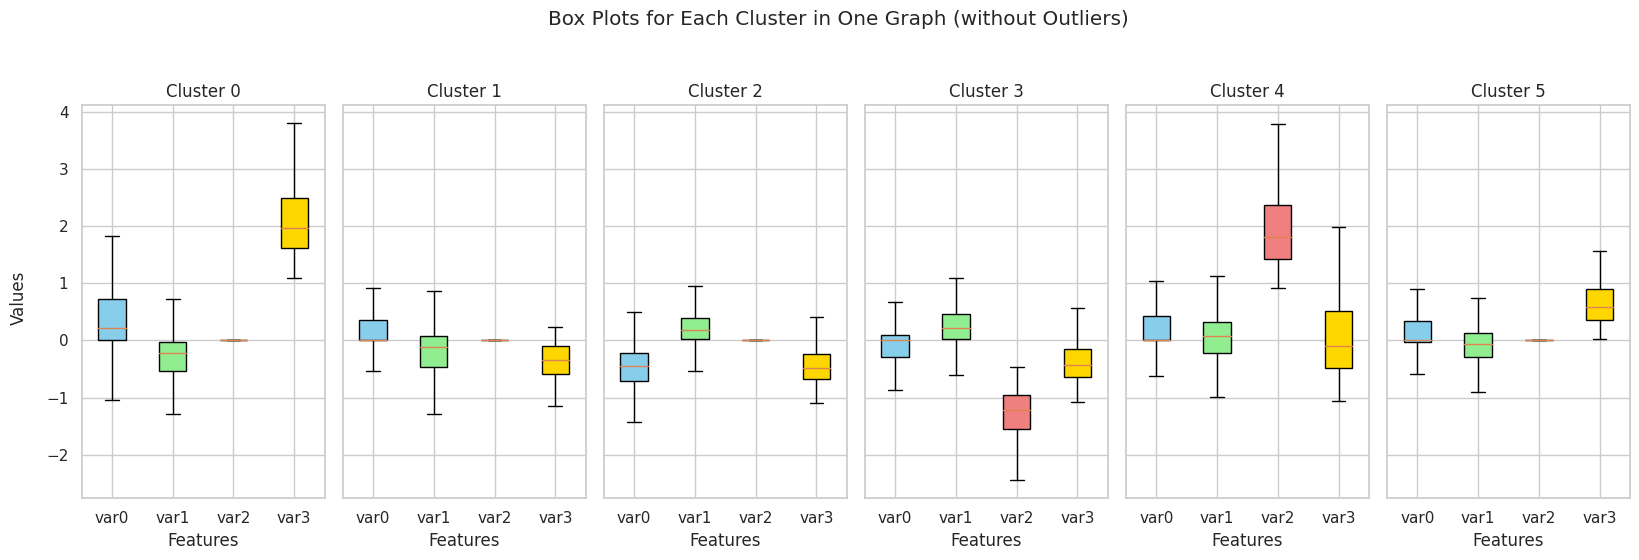

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the data from pickle file
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

# Define colors for each feature
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

# Grouping the data by 'CLUSTER' column
grouped_data = clustered_data.groupby('CLUSTER')

# Calculate mean and standard deviation for each feature in each cluster
means = []
std_devs = []
for cluster, cluster_data in grouped_data:
    cluster_means = cluster_data[['var0', 'var1', 'var2', 'var3']].mean()
    cluster_std_devs = cluster_data[['var0', 'var1', 'var2', 'var3']].std()
    means.append(cluster_means)
    std_devs.append(cluster_std_devs)

# Combine data for boxplot
boxplot_data = [cluster_data[['var0', 'var1', 'var2', 'var3']] for cluster, cluster_data in grouped_data]

# Creating the box plot for all clusters in one graph with a shared y-axis
fig, axs = plt.subplots(1, len(grouped_data), figsize=(18, 6), sharey=True)

# Loop through each cluster and create a box plot in the shared y-axis graph
for idx, (cluster, cluster_data) in enumerate(grouped_data):
    bp = axs[idx].boxplot(cluster_data[['var0', 'var1', 'var2', 'var3']], showfliers=False, patch_artist=True)

    # Set colors for each box
    for box, color in zip(bp['boxes'], colors):
        box.set(facecolor=color)  # Set the color of the box

    axs[idx].set_title(f'Cluster {cluster}')
    axs[idx].set_xlabel('Features')
    axs[idx].set_xticklabels(['var0', 'var1', 'var2', 'var3'])
    axs[idx].grid(True)

# Set common y-axis label
fig.text(0.04, 0.5, 'Values', va='center', rotation='vertical')

# Set title and adjust layout
plt.suptitle('Box Plots for Each Cluster in One Graph (without Outliers)')
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()


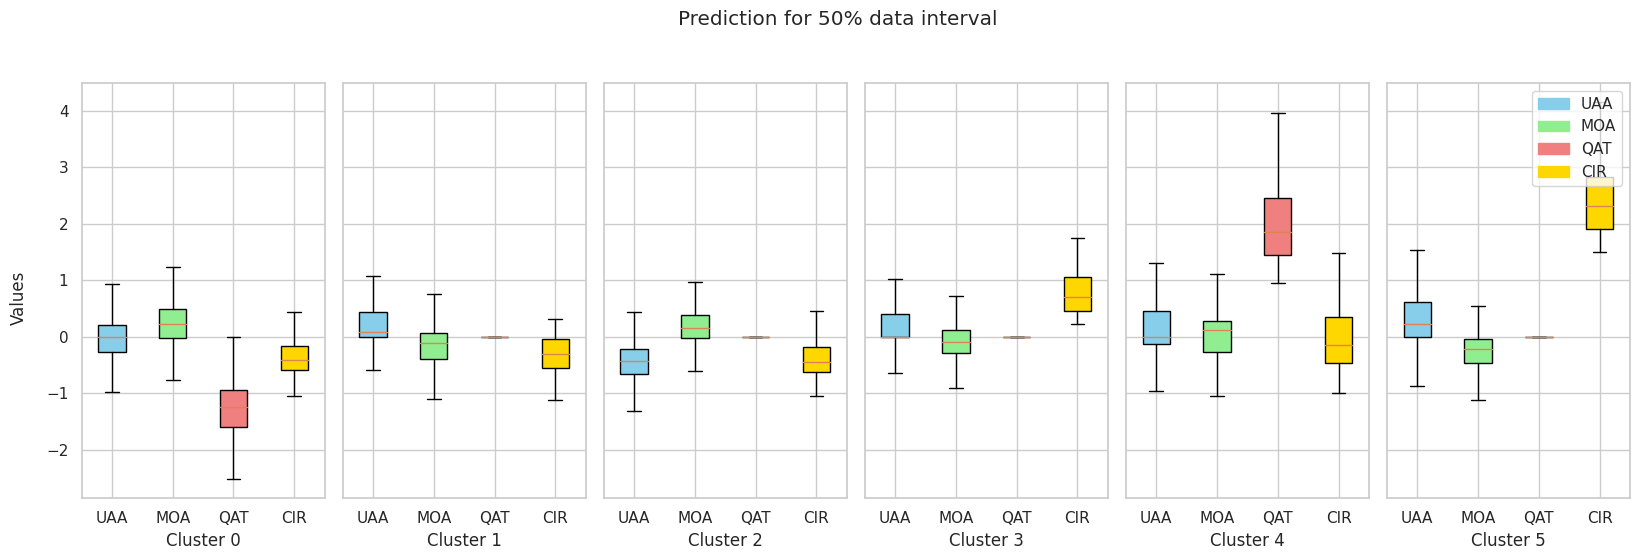

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Read the data from pickle file
clustered_data = pd.read_pickle('/content/output_agg_simple_50.pkl')

# Define colors for each feature
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

# Grouping the data by 'CLUSTER' column
grouped_data = clustered_data.groupby('CLUSTER')

# Calculate mean and standard deviation for each feature in each cluster
means = []
std_devs = []
for cluster, cluster_data in grouped_data:
    cluster_means = cluster_data[['var0', 'var1', 'var2', 'var3']].mean()
    cluster_std_devs = cluster_data[['var0', 'var1', 'var2', 'var3']].std()
    means.append(cluster_means)
    std_devs.append(cluster_std_devs)

# Create a figure for the plot
fig, axs = plt.subplots(1, len(grouped_data), figsize=(18, 6), sharey=True)

# Loop through each cluster and create a box plot in the shared y-axis graph
for idx, (cluster, cluster_data) in enumerate(grouped_data):
    bp = axs[idx].boxplot(cluster_data[['var0', 'var1', 'var2', 'var3']], showfliers=False, patch_artist=True)

    # Set colors for each box
    for box, color in zip(bp['boxes'], colors):
        box.set(facecolor=color)  # Set the color of the box

    # axs[idx].set_title(f'Prediction for 50% data interval')
    axs[idx].set_xlabel(f'Cluster {cluster}')
    # axs[idx].set_xlabel('Features')
    axs[idx].set_xticklabels(['UAA', 'MOA', 'QAT', 'CIR'])
    axs[idx].grid(True)

# Set common y-axis label
fig.text(0.04, 0.5, 'Values', va='center', rotation='vertical')

#'UAA', 'MOA', 'QAT', 'CIR'

# Create legend handles
#legend_handles = [mpatches.Patch(color=color, label=f'Feature {i+1}') for i, color in enumerate(colors)]
legend_handles = [mpatches.Patch(color=color, label=f'{feature}') for color, feature in zip(colors, ['UAA', 'MOA', 'QAT', 'CIR'])]

# Add legend
plt.legend(handles=legend_handles, loc='upper right')

# Set title and adjust layout
plt.suptitle('Prediction for 50% data interval')
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()


CODE for **all** **bold text**

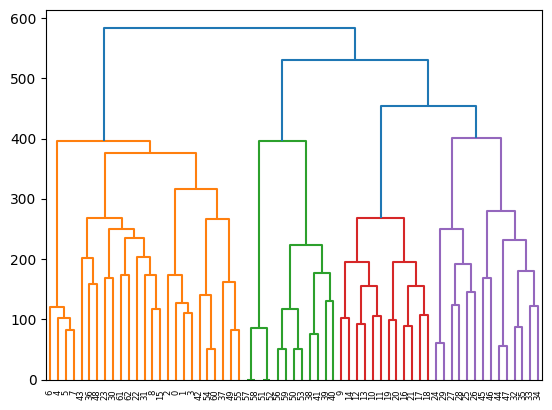

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


cluster labels are :
[1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 1 3 3 3 3 3 3 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1
 1 2 2 2 2 1 1 0 0 0 0 1 1 2 2 2 2 1 1 2 2 2 2 1 1 1]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


In [ ]:
# imports
import logging as log
import os
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.cluster as cluster
import sklearn.preprocessing as pre
from gap_statistic import OptimalK
from scipy.cluster import hierarchy
from scipy.stats import mode
from sklearn.impute import SimpleImputer

# get variables
'''
data_path = str(sys.argv[1])
time = float(sys.argv[2])
process_type = sys.argv[3] if len(sys.argv) > 3 else 'none'
'''
data_path = '/content/'
time = 0.10
num_features = 4
time_percent = int(100 * time)

# logger
prefix = datetime.now().strftime('%Y%m%d_%H%M%S')
log_name = prefix + '_clustering_select_best_' + str(time_percent)


import sys

log.basicConfig(stream=sys.stdout, level=log.INFO, format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

log.basicConfig(filename=os.path.join(data_path,  log_name + '.log'), filemode='w', level=log.INFO,
                format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

# ------------------ read data -----------------------
data = pd.read_csv(os.path.join(data_path,  'input_' + str(time_percent) + '.csv'), sep='#')
data.drop(data.columns[0], axis=1, inplace=True)
# print ("data head is ")

ids = data['UID']
course = data['COURSE']
target = data['TARGET']

# get labels (y) and dataset (df)
data.drop('UID', axis=1, inplace=True, errors='ignore')
data.drop('COURSE', axis=1, inplace=True, errors='ignore')
data.drop('TARGET', axis=1, inplace=True, errors='ignore')
data.drop('NP_TARGET', axis=1, inplace=True, errors='ignore')
data.drop('ALL_GRADES_PAST', axis=1, inplace=True, errors='ignore')
data.drop('NP_ACCOMPLISH_MANDATORY_GRADE', axis=1, inplace=True, errors='ignore')
data.drop('NP_ACCOMPLISH_OPTIONAL_GRADE', axis=1, inplace=True, errors='ignore')
log.info('Original shape {}'.format(data.shape))

# ------------------- change -1 values by mean -------------------

cols = data.columns

data = data.replace(-1, np.nan)
data = data.replace(-1.0, np.nan)
# print(data.head)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_without_null = imp.fit_transform(data)
pickle.dump(imp, open(os.path.join(data_path,  str(time_percent) + '_imputer.pkl'), 'wb'))

scaler = pre.StandardScaler()
scaled_data = scaler.fit_transform(df_without_null)
pickle.dump(scaler, open(os.path.join(data_path, str(time_percent) + '_scaler.pkl'), 'wb'))
data = pd.DataFrame(scaled_data, columns=cols)

Z = hierarchy.linkage(np.transpose(scaled_data), 'ward')
plt.figure()
dn = hierarchy.dendrogram(Z)
plt.show()

cluster_process = cluster.FeatureAgglomeration(n_clusters=num_features, affinity='euclidean', linkage='ward')
data_agg = cluster_process.fit_transform(data)
pickle.dump(cluster_process, open(os.path.join(data_path,  str(time_percent) + '_aggregator.pkl'), 'wb'))

log.info(cluster_process.labels_)
print("cluster labels are :")
print(cluster_process.labels_)

for i in range(num_features):
    log.info(' '.join(cols[cluster_process.labels_ == i]))

# num_clusters_list = []
# for i in range(1, 100):
#     optimalK = OptimalK()
#     try:
#         num_clusters_list.append(optimalK(data_agg, cluster_array=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))
#     except:
#         num_clusters_list.append(0)

# print("num_clusters_list are :")
# print(num_clusters_list)
# num_cluster = mode(num_clusters_list)[0]
# print('Number of clusters = {}'.format(num_cluster))
# log.info('Number of clusters = {}'.format(num_cluster))

cluster_data_process = cluster.KMeans(n_clusters=6, init='k-means++', tol=0.0001, algorithm='auto',
                                      n_init=200)

data2 = cluster_data_process.fit_predict(data_agg)
pickle.dump(cluster_data_process, open(os.path.join(data_path,  str(time_percent) + '_cluster.pkl'), 'wb'))

log.info('Unique clusters {}'.format(np.unique(data2)))
log.info('Centroids {}'.format(cluster_data_process.cluster_centers_))

new_cols = []
for i in range(num_features):
    new_cols.append('var' + str(i))

X = pd.DataFrame(data_agg, columns=new_cols)

X.loc[:, 'UID'] = pd.Series(ids, index=X.index)
X.loc[:, 'COURSE'] = pd.Series(course, index=X.index)
X.loc[:, 'TARGET'] = pd.Series(target, index=X.index)
X.loc[:, 'CLUSTER'] = pd.Series(data2, index=X.index)

X.to_pickle(os.path.join(data_path,  'output_agg_simple_' + str(time_percent) + '.pkl'))

data.loc[:, 'UID'] = pd.Series(ids, index=data.index)
data.loc[:, 'COURSE'] = pd.Series(course, index=data.index)
data.loc[:, 'TARGET'] = pd.Series(target, index=data.index)
data.loc[:, 'CLUSTER'] = pd.Series(data2, index=data.index)

data.to_pickle(os.path.join(data_path,  'output_agg_all_' + str(time_percent) + '.pkl'))

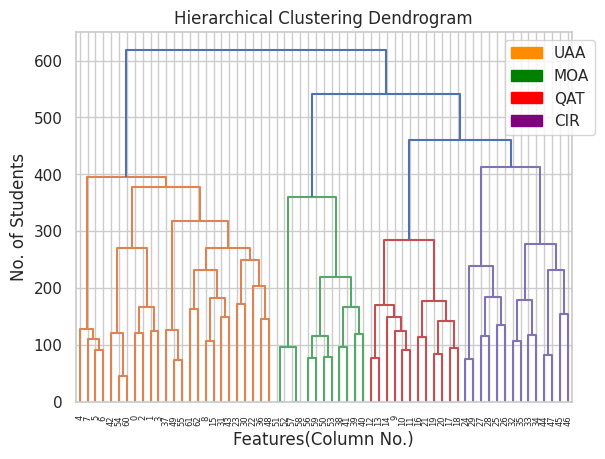

In [ ]:
Z = hierarchy.linkage(np.transpose(scaled_data), 'ward')
plt.figure()
plt.xlabel('Features(Column No.)')
plt.ylabel('No. of Students')
plt.title('Hierarchical Clustering Dendrogram')
legend_handles = [
    mpatches.Patch(color='darkorange', label='UAA'),
    mpatches.Patch(color='green', label='MOA'),
    mpatches.Patch(color='red', label='QAT'),
    mpatches.Patch(color='purple', label='CIR')
]

# Add the custom legend outside the plot for clarity
plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(0.85, 0.85))

dn = hierarchy.dendrogram(Z)
plt.show()


for 10%

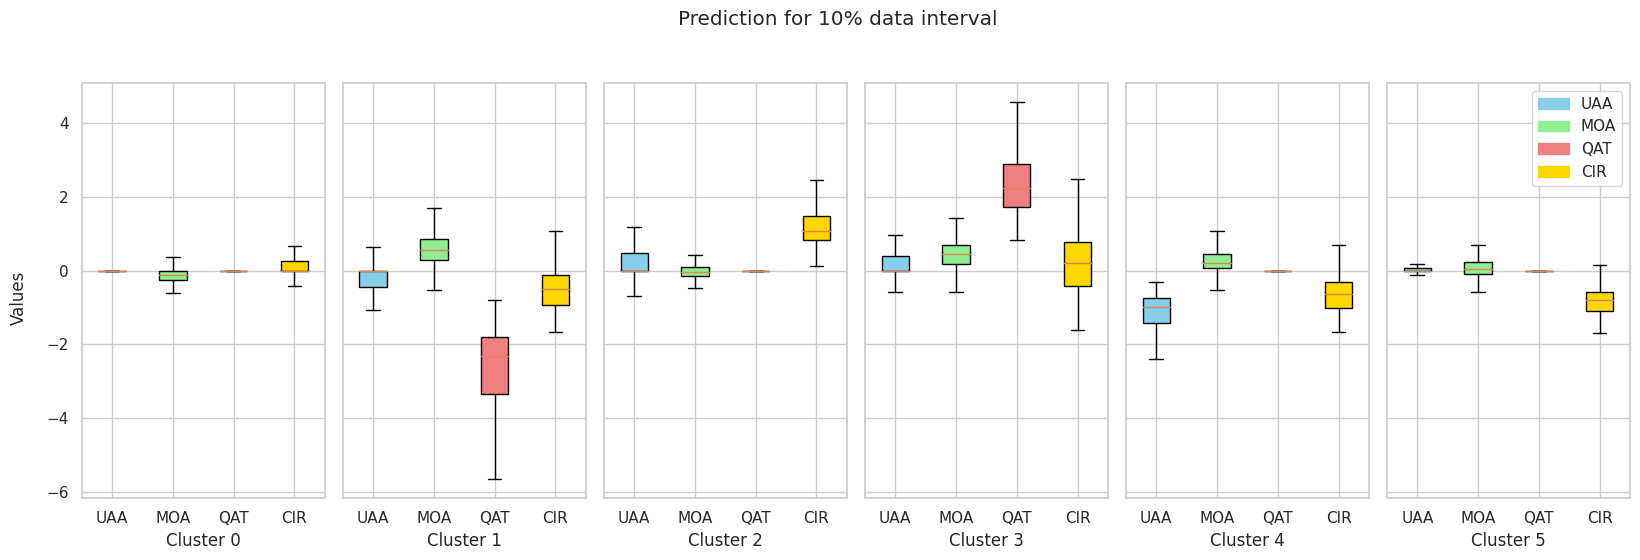

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Read the data from pickle file
clustered_data = pd.read_pickle('/content/output_agg_simple_10.pkl')

# Define colors for each feature
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

# Grouping the data by 'CLUSTER' column
grouped_data = clustered_data.groupby('CLUSTER')

# Calculate mean and standard deviation for each feature in each cluster
means = []
std_devs = []
for cluster, cluster_data in grouped_data:
    cluster_means = cluster_data[['var0', 'var1', 'var2', 'var3']].mean()
    cluster_std_devs = cluster_data[['var0', 'var1', 'var2', 'var3']].std()
    means.append(cluster_means)
    std_devs.append(cluster_std_devs)

# Create a figure for the plot
fig, axs = plt.subplots(1, len(grouped_data), figsize=(18, 6), sharey=True)

# Loop through each cluster and create a box plot in the shared y-axis graph
for idx, (cluster, cluster_data) in enumerate(grouped_data):
    bp = axs[idx].boxplot(cluster_data[['var0', 'var1', 'var2', 'var3']], showfliers=False, patch_artist=True)

    # Set colors for each box
    for box, color in zip(bp['boxes'], colors):
        box.set(facecolor=color)  # Set the color of the box

    # axs[idx].set_title(f'Prediction for 50% data interval')
    axs[idx].set_xlabel(f'Cluster {cluster}')
    # axs[idx].set_xlabel('Features')
    axs[idx].set_xticklabels(['UAA', 'MOA', 'QAT', 'CIR'])
    axs[idx].grid(True)

# Set common y-axis label
fig.text(0.04, 0.5, 'Values', va='center', rotation='vertical')

#'UAA', 'MOA', 'QAT', 'CIR'

# Create legend handles
#legend_handles = [mpatches.Patch(color=color, label=f'Feature {i+1}') for i, color in enumerate(colors)]
legend_handles = [mpatches.Patch(color=color, label=f'{feature}') for color, feature in zip(colors, ['UAA', 'MOA', 'QAT', 'CIR'])]

# Add legend
plt.legend(handles=legend_handles, loc='upper right')

# Set title and adjust layout
plt.suptitle('Prediction for 10% data interval')
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()


for 25%

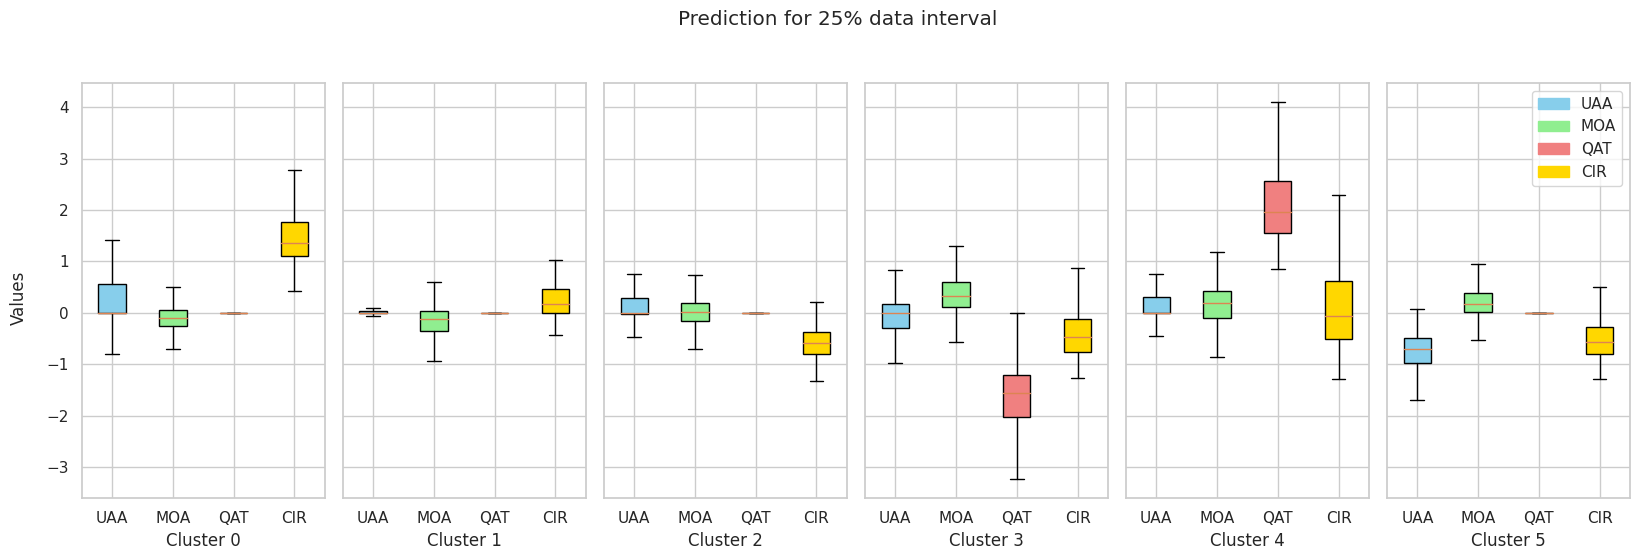

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Read the data from pickle file
clustered_data = pd.read_pickle('/content/output_agg_simple_25.pkl')

# Define colors for each feature
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

# Grouping the data by 'CLUSTER' column
grouped_data = clustered_data.groupby('CLUSTER')

# Calculate mean and standard deviation for each feature in each cluster
means = []
std_devs = []
for cluster, cluster_data in grouped_data:
    cluster_means = cluster_data[['var0', 'var1', 'var2', 'var3']].mean()
    cluster_std_devs = cluster_data[['var0', 'var1', 'var2', 'var3']].std()
    means.append(cluster_means)
    std_devs.append(cluster_std_devs)

# Create a figure for the plot
fig, axs = plt.subplots(1, len(grouped_data), figsize=(18, 6), sharey=True)

# Loop through each cluster and create a box plot in the shared y-axis graph
for idx, (cluster, cluster_data) in enumerate(grouped_data):
    bp = axs[idx].boxplot(cluster_data[['var0', 'var1', 'var2', 'var3']], showfliers=False, patch_artist=True)

    # Set colors for each box
    for box, color in zip(bp['boxes'], colors):
        box.set(facecolor=color)  # Set the color of the box

    # axs[idx].set_title(f'Prediction for 50% data interval')
    axs[idx].set_xlabel(f'Cluster {cluster}')
    # axs[idx].set_xlabel('Features')
    axs[idx].set_xticklabels(['UAA', 'MOA', 'QAT', 'CIR'])
    axs[idx].grid(True)

# Set common y-axis label
fig.text(0.04, 0.5, 'Values', va='center', rotation='vertical')

#'UAA', 'MOA', 'QAT', 'CIR'

# Create legend handles
#legend_handles = [mpatches.Patch(color=color, label=f'Feature {i+1}') for i, color in enumerate(colors)]
legend_handles = [mpatches.Patch(color=color, label=f'{feature}') for color, feature in zip(colors, ['UAA', 'MOA', 'QAT', 'CIR'])]

# Add legend
plt.legend(handles=legend_handles, loc='upper right')

# Set title and adjust layout
plt.suptitle('Prediction for 25% data interval')
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()


for 33%

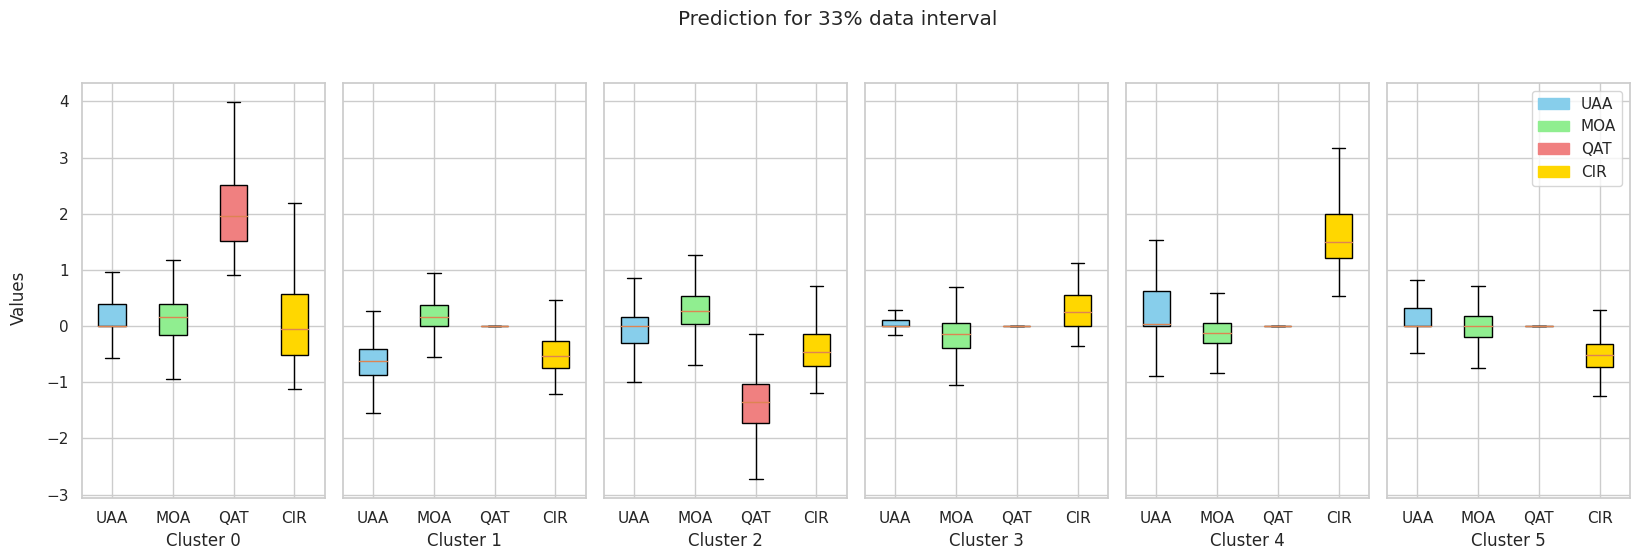

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Read the data from pickle file
clustered_data = pd.read_pickle('/content/output_agg_simple_33.pkl')

# Define colors for each feature
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

# Grouping the data by 'CLUSTER' column
grouped_data = clustered_data.groupby('CLUSTER')

# Calculate mean and standard deviation for each feature in each cluster
means = []
std_devs = []
for cluster, cluster_data in grouped_data:
    cluster_means = cluster_data[['var0', 'var1', 'var2', 'var3']].mean()
    cluster_std_devs = cluster_data[['var0', 'var1', 'var2', 'var3']].std()
    means.append(cluster_means)
    std_devs.append(cluster_std_devs)

# Create a figure for the plot
fig, axs = plt.subplots(1, len(grouped_data), figsize=(18, 6), sharey=True)

# Loop through each cluster and create a box plot in the shared y-axis graph
for idx, (cluster, cluster_data) in enumerate(grouped_data):
    bp = axs[idx].boxplot(cluster_data[['var0', 'var1', 'var2', 'var3']], showfliers=False, patch_artist=True)

    # Set colors for each box
    for box, color in zip(bp['boxes'], colors):
        box.set(facecolor=color)  # Set the color of the box

    # axs[idx].set_title(f'Prediction for 50% data interval')
    axs[idx].set_xlabel(f'Cluster {cluster}')
    # axs[idx].set_xlabel('Features')
    axs[idx].set_xticklabels(['UAA', 'MOA', 'QAT', 'CIR'])
    axs[idx].grid(True)

# Set common y-axis label
fig.text(0.04, 0.5, 'Values', va='center', rotation='vertical')

#'UAA', 'MOA', 'QAT', 'CIR'

# Create legend handles
#legend_handles = [mpatches.Patch(color=color, label=f'Feature {i+1}') for i, color in enumerate(colors)]
legend_handles = [mpatches.Patch(color=color, label=f'{feature}') for color, feature in zip(colors, ['UAA', 'MOA', 'QAT', 'CIR'])]

# Add legend
plt.legend(handles=legend_handles, loc='upper right')

# Set title and adjust layout
plt.suptitle('Prediction for 33% data interval')
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()


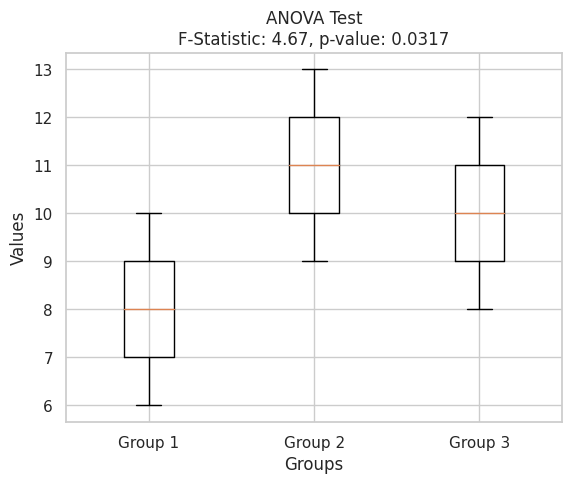

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats

# Sample data for three groups (e.g., treatment groups)
group1 = [6, 7, 8, 9, 10]
group2 = [9, 10, 11, 12, 13]
group3 = [8, 9, 10, 11, 12]

# Perform ANOVA test
f_statistic, p_value = stats.f_oneway(group1, group2, group3)

# Create a box plot to visualize the data distribution
plt.boxplot([group1, group2, group3])
plt.xticks([1, 2, 3], ['Group 1', 'Group 2', 'Group 3'])
plt.xlabel('Groups')
plt.ylabel('Values')
plt.title('ANOVA Test\nF-Statistic: {:.2f}, p-value: {:.4f}'.format(f_statistic, p_value))
plt.grid(True)
plt.show()


Finding mean and SD

In [ ]:
import pandas as pd

# Read the data from pickle file
clustered_data = pd.read_pickle('/content/output_agg_simple_33.pkl')

# Calculate N (number of students per group)
group_counts = clustered_data.groupby('CLUSTER').size().reset_index(name='N')

# Calculate variable average and standard deviation per cluster for each feature
cluster_stats = clustered_data.groupby('CLUSTER').agg({
    'var0': ['mean', 'std'],
    'var1': ['mean', 'std'],
    'var2': ['mean', 'std'],
    'var3': ['mean', 'std']
})

# Save group counts to CSV
group_counts.to_csv('/content/group_counts.csv', index=False)

# Save cluster statistics to CSV
cluster_stats.to_csv('/content/cluster_stats_33.csv')

# Print the results
print("Number of students per group (N):")
print(group_counts)
print("\nVariable average and standard deviation per cluster:")
print(cluster_stats)



Number of students per group (N):
   CLUSTER     N
0        0  1450
1        1  4117
2        2  2459
3        3  7464
4        4  2510
5        5  7260

Variable average and standard deviation per cluster:
             var0                var1                var2                var3  \
             mean       std      mean       std      mean       std      mean   
CLUSTER                                                                         
0        0.182152  0.523873  0.156473  0.519273  2.095420  0.754162  0.115557   
1       -0.691264  0.392396  0.242915  0.430118  0.016909  0.261801 -0.485582   
2       -0.046963  0.507257  0.343668  0.606796 -1.432306  0.488170 -0.375549   
3        0.072378  0.332233 -0.205267  0.405914  0.009225  0.215524  0.313262   
4        0.346596  0.525810 -0.139616  0.390192  0.084745  0.356857  1.677828   
5        0.177288  0.388000 -0.026101  0.392712  0.018251  0.266739 -0.522655   

                   
              std  
CLUSTER            
0  

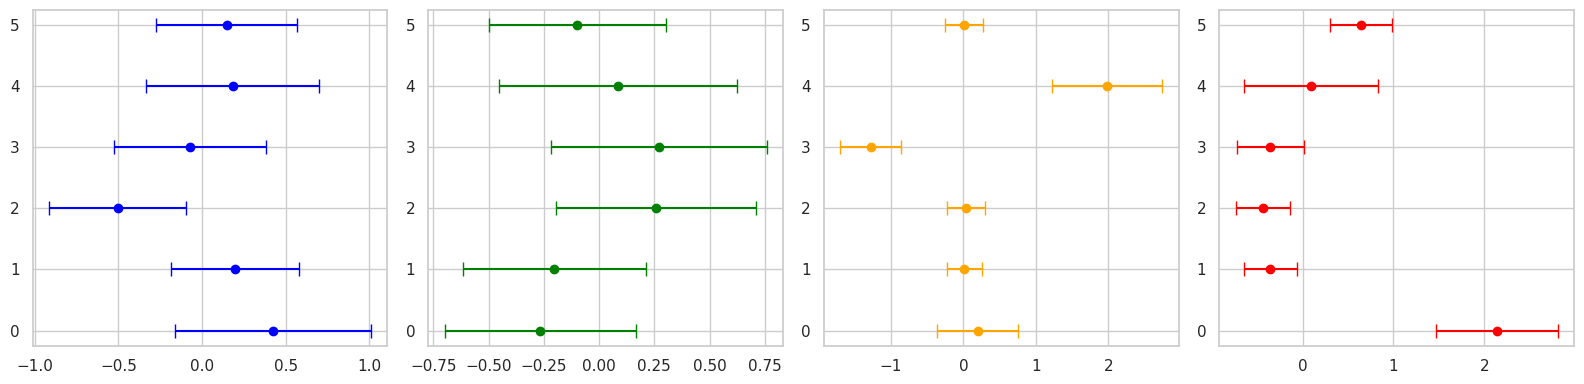

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data
data = {
    'CLUSTER': [0, 1, 2, 3, 4, 5],
    'var0_mean': [0.426557632454125, 0.197928620516435, -0.504954457603559, -0.0712567874464192, 0.1840563387499, 0.148235670956838],
    'var0_std': [0.586282125296238, 0.381560461327407, 0.409288982605003, 0.454506605846898, 0.518028476601721, 0.421595729538194],
    'var1_mean': [-0.266320193778295, -0.202663241239892, 0.256270605778184, 0.271965770921559, 0.0859352609430308, -0.0982070758678995],
    'var1_std': [0.433147628204822, 0.413968528008622, 0.452319672687475, 0.487582806542957, 0.537361977062456, 0.40078642035269],
    'var2_mean': [0.199681324262184, 0.0111019749646005, 0.0373081860551114, -1.27922115734462, 1.98758360608782, 0.0108503632304891],
    'var2_std': [0.558934068417655, 0.242425193698437, 0.2661166232913, 0.422125225014844, 0.75839225928855, 0.265404862358664],
    'var3_mean': [2.13869267129091, -0.35421484292008, -0.437456731859813, -0.356693879423355, 0.0930415994625353, 0.641802772709454],
    'var3_std': [0.671435894456036, 0.292972293353688, 0.300924862899234, 0.370842516775935, 0.73426976693624, 0.345837575522071]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

variables = ['var0', 'var1', 'var2', 'var3']
colors = ['blue', 'green', 'orange', 'red']

for i, var in enumerate(variables):
    axs[i].errorbar(df[var + '_mean'], df['CLUSTER'], xerr=df[var + '_std'], fmt='o', color=colors[i], capsize=5)
    # axs[i].set_title(f'{var.capitalize()} Mean and Std')
    # axs[i].set_xlabel('Value')
    # axs[i].set_ylabel('Cluster')
    axs[i].grid(True)
    axs[i].set_yticks(df['CLUSTER'])

plt.tight_layout()
plt.show()


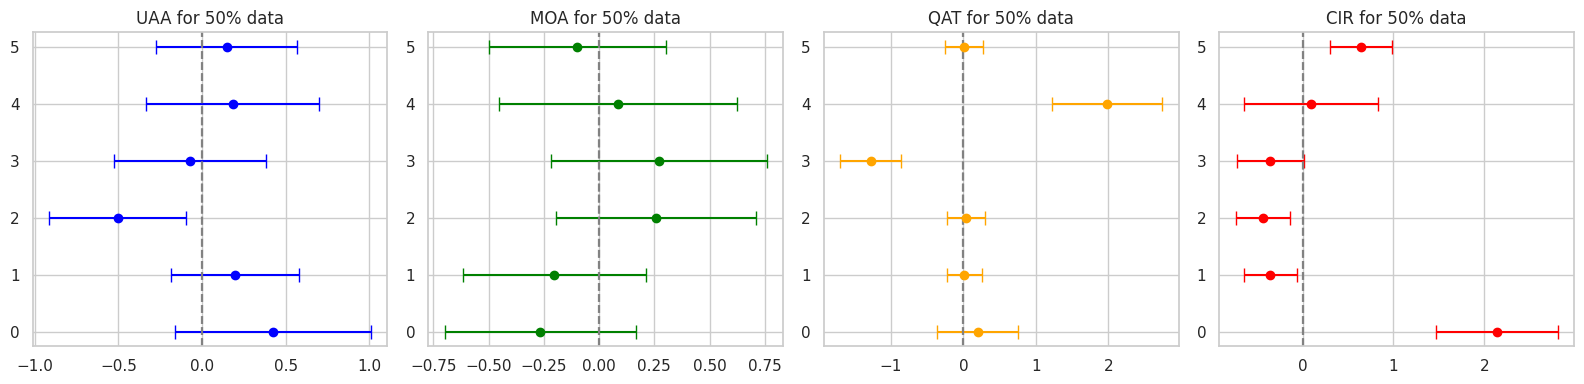

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data
# for 50%
# data = {
#     'CLUSTER': [0, 1, 2, 3, 4, 5],
#     'var0_mean': [0.426557632454125, 0.197928620516435, -0.504954457603559, -0.0712567874464192, 0.1840563387499, 0.148235670956838],
#     'var0_std': [0.586282125296238, 0.381560461327407, 0.409288982605003, 0.454506605846898, 0.518028476601721, 0.421595729538194],
#     'var1_mean': [-0.266320193778295, -0.202663241239892, 0.256270605778184, 0.271965770921559, 0.0859352609430308, -0.0982070758678995],
#     'var1_std': [0.433147628204822, 0.413968528008622, 0.452319672687475, 0.487582806542957, 0.537361977062456, 0.40078642035269],
#     'var2_mean': [0.199681324262184, 0.0111019749646005, 0.0373081860551114, -1.27922115734462, 1.98758360608782, 0.0108503632304891],
#     'var2_std': [0.558934068417655, 0.242425193698437, 0.2661166232913, 0.422125225014844, 0.75839225928855, 0.265404862358664],
#     'var3_mean': [2.13869267129091, -0.35421484292008, -0.437456731859813, -0.356693879423355, 0.0930415994625353, 0.641802772709454],
#     'var3_std': [0.671435894456036, 0.292972293353688, 0.300924862899234, 0.370842516775935, 0.73426976693624, 0.345837575522071]
# }



# Create a DataFrame
df = pd.DataFrame(data)

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

variables = ['var0', 'var1', 'var2', 'var3']
titles = ['UAA for 50% data', 'MOA for 50% data', 'QAT for 50% data', 'CIR for 50% data']
colors = ['blue', 'green', 'orange', 'red']

for i, (var, title) in enumerate(zip(variables, titles)):
    axs[i].errorbar(df[var + '_mean'], df['CLUSTER'], xerr=df[var + '_std'], fmt='o', color=colors[i], capsize=5)
    axs[i].set_title(title)
    # axs[i].set_xlabel('Value')
    # axs[i].set_ylabel('Cluster')
    axs[i].grid(True)
    axs[i].set_yticks(df['CLUSTER'])

    # Add a dotted line at value 0 for clusters other than Cluster 0
    for cluster, mean_value in zip(df['CLUSTER'], df[var + '_mean']):
        if cluster != 0:
            axs[i].axvline(x=0, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()


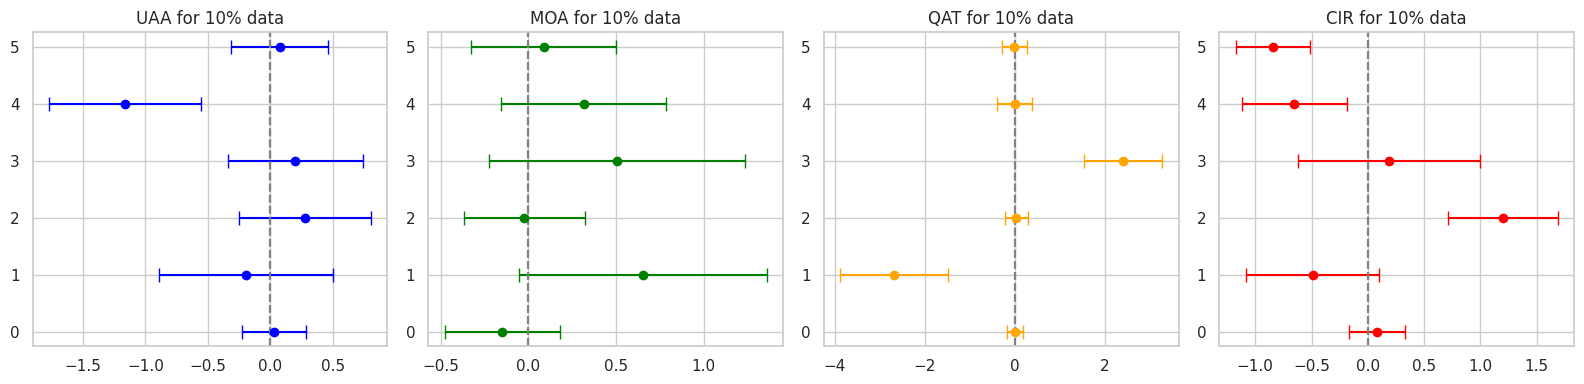

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data
data = {
    'CLUSTER': [0, 1, 2, 3, 4, 5],
    'var0_mean': [0.0284229196774715, -0.193977805542911, 0.281164825032539, 0.201622929736079, -1.16348965321477, 0.0749095493238007],
    'var0_std': [0.255849828061988, 0.7006838219981, 0.529747809905841, 0.543203001135995, 0.60840271841351, 0.385530859187293],
    'var1_mean': [-0.150632768625059, 0.651461808215899, -0.0237176093381871, 0.506061848595289, 0.315064361000023, 0.0858080241679569],
    'var1_std': [0.327930138592113, 0.708011082078105, 0.345362754965726, 0.729369511099923, 0.471508697003566, 0.412312014081056],
    'var2_mean': [-0.00207363378878352, -2.68791232097363, 0.0328390226552711, 2.39691754282783, -0.00918399275675042, -0.0126787013454886],
    'var2_std': [0.174366505781961, 1.19429030804015, 0.249709018000984, 0.873397722662676, 0.389086764006179, 0.286039880070199],
    'var3_mean': [0.0843267532613906, -0.488457524401997, 1.19925131156634, 0.186162118899752, -0.653110000969077, -0.843743815901379],
    'var3_std': [0.250028447904358, 0.590539124541256, 0.489201907598287, 0.807559671603712, 0.464526644739206, 0.330908928015575]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

variables = ['var0', 'var1', 'var2', 'var3']
titles = ['UAA for 10% data', 'MOA for 10% data', 'QAT for 10% data', 'CIR for 10% data']
colors = ['blue', 'green', 'orange', 'red']

for i, (var, title) in enumerate(zip(variables, titles)):
    axs[i].errorbar(df[var + '_mean'], df['CLUSTER'], xerr=df[var + '_std'], fmt='o', color=colors[i], capsize=5)
    axs[i].set_title(title)
    # axs[i].set_xlabel('Value')
    # axs[i].set_ylabel('Cluster')
    axs[i].grid(True)
    axs[i].set_yticks(df['CLUSTER'])

    # Add a dotted line at value 0 for clusters other than Cluster 0
    for cluster, mean_value in zip(df['CLUSTER'], df[var + '_mean']):
        if cluster != 0:
            axs[i].axvline(x=0, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()


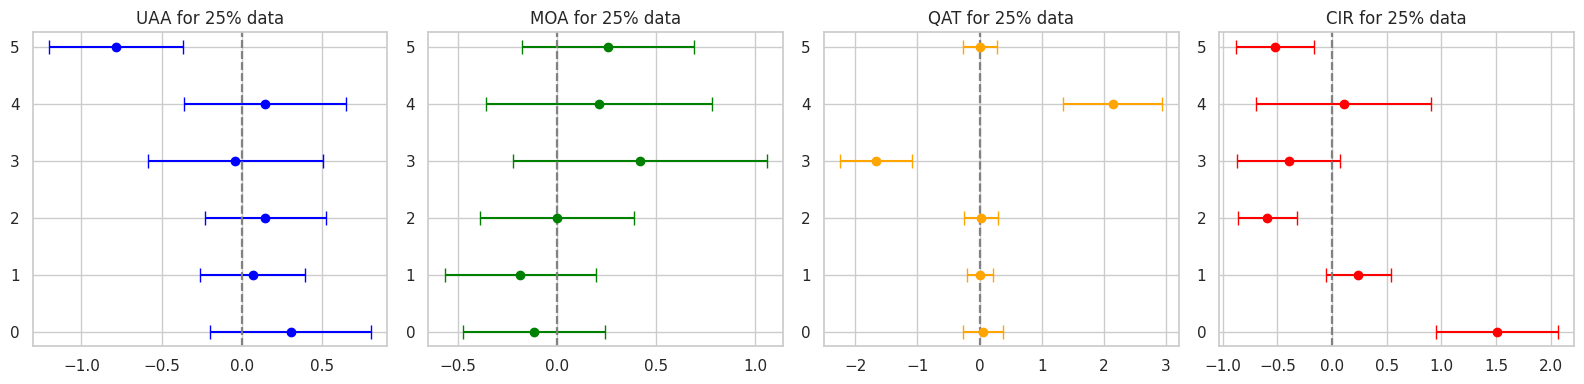

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data
data = {
    'CLUSTER': [0, 1, 2, 3, 4, 5],
    'var0_mean': [0.302799789511696, 0.0663258189636139, 0.145885951041385, -0.0428612824252976, 0.145500260928059, -0.785480401479274],
    'var0_std': [0.503415409610913, 0.329150658268039, 0.379119911878005, 0.54464630921233, 0.504153607488767, 0.416171871937671],
    'var1_mean': [-0.113998274237653, -0.185199501566887, -0.000406547157647304, 0.419166991116515, 0.212807175417608, 0.258206506905786],
    'var1_std': [0.359252984781368, 0.381207525788736, 0.388555898646766, 0.641434939419724, 0.570049538890547, 0.435555304930555],
    'var2_mean': [0.059073369254378, 0.00655645858874298, 0.0153044476037224, -1.66534714322461, 2.14134693300349, -0.000311203237465732],
    'var2_std': [0.324168810019187, 0.211630258740417, 0.274134631391002, 0.580544890999976, 0.798943263587401, 0.275199575363271],
    'var3_mean': [1.50821411120702, 0.23970752210634, -0.594390411688574, -0.398380455911769, 0.107478889909988, -0.526925412770298],
    'var3_std': [0.55638718096434, 0.297863165875787, 0.268913163407796, 0.474413148534496, 0.799494268835541, 0.356584943302115]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

variables = ['var0', 'var1', 'var2', 'var3']
titles = ['UAA for 25% data', 'MOA for 25% data', 'QAT for 25% data', 'CIR for 25% data']
colors = ['blue', 'green', 'orange', 'red']

for i, (var, title) in enumerate(zip(variables, titles)):
    axs[i].errorbar(df[var + '_mean'], df['CLUSTER'], xerr=df[var + '_std'], fmt='o', color=colors[i], capsize=5)
    axs[i].set_title(title)
    # axs[i].set_xlabel('Value')
    # axs[i].set_ylabel('Cluster')
    axs[i].grid(True)
    axs[i].set_yticks(df['CLUSTER'])

    # Add a dotted line at value 0 for clusters other than Cluster 0
    for cluster, mean_value in zip(df['CLUSTER'], df[var + '_mean']):
        if cluster != 0:
            axs[i].axvline(x=0, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()


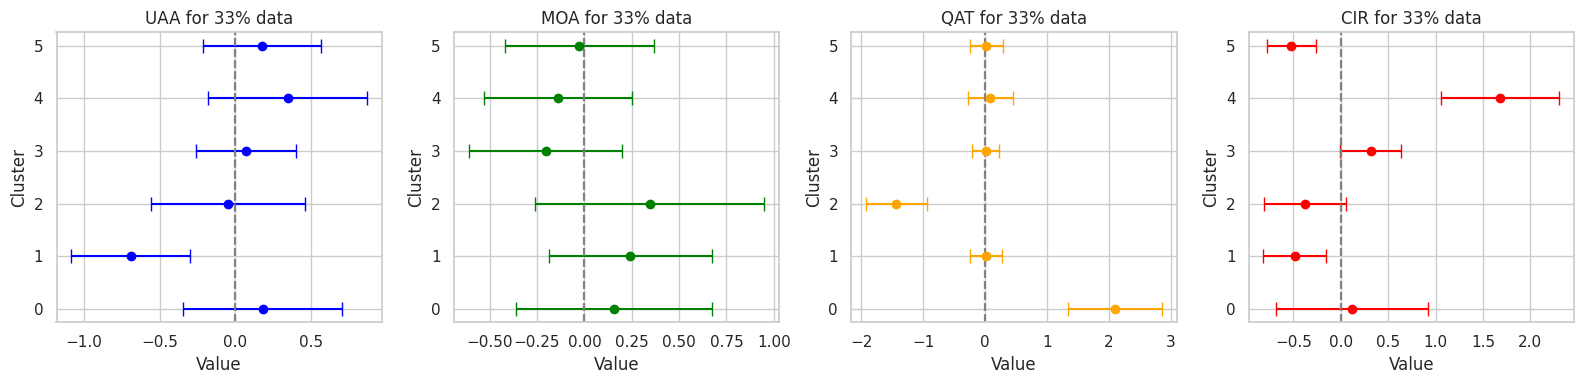

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data
data = {
    'CLUSTER': [0, 1, 2, 3, 4, 5],
    'var0_mean': [0.182152439743908, -0.69126410564794, -0.046963417077118, 0.0723777203750612, 0.346595837332714, 0.177288356932778],
    'var0_std': [0.523873203114015, 0.392396456684798, 0.507256766009581, 0.332233198928273, 0.525809975341979, 0.387999927414751],
    'var1_mean': [0.156473338836586, 0.242914661939236, 0.343668497047883, -0.205267188749176, -0.139616281423677, -0.0261013327218115],
    'var1_std': [0.519272542810138, 0.430118026379217, 0.60679565287944, 0.405914474041336, 0.390192461010943, 0.39271245621403],
    'var2_mean': [2.09542046770746, 0.0169086200667533, -1.432305945712, 0.00922474653826114, 0.0847450941385775, 0.0182512615793051],
    'var2_std': [0.754162127217803, 0.26180121680034, 0.488170248132926, 0.215524094985253, 0.356857234326453, 0.266739027181345],
    'var3_mean': [0.11555695881177, -0.485581678206585, -0.37554939809686, 0.313262113659758, 1.67782776644598, -0.522655366572483],
    'var3_std': [0.799989956092557, 0.330902856650812, 0.433311094611614, 0.320504326262793, 0.626191707577488, 0.261548920659262]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

variables = ['var0', 'var1', 'var2', 'var3']
titles = ['UAA for 33% data', 'MOA for 33% data', 'QAT for 33% data', 'CIR for 33% data']
colors = ['blue', 'green', 'orange', 'red']

for i, (var, title) in enumerate(zip(variables, titles)):
    axs[i].errorbar(df[var + '_mean'], df['CLUSTER'], xerr=df[var + '_std'], fmt='o', color=colors[i], capsize=5)
    axs[i].set_title(title)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Cluster')
    axs[i].grid(True)
    axs[i].set_yticks(df['CLUSTER'])

    # Add a dotted line at value 0 for clusters other than Cluster 0
    for cluster, mean_value in zip(df['CLUSTER'], df[var + '_mean']):
        if cluster != 0:
            axs[i].axvline(x=0, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()


**STUDENT PERFORMANCE AND CLUSTER RELATION**

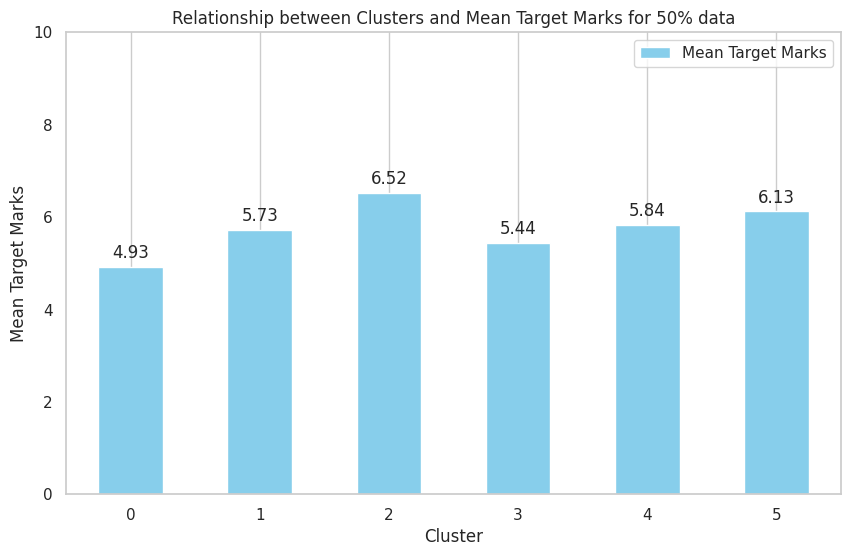

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the output data with cluster assignments and target marks
output_data_path = '/content/output_agg_simple_10.pkl'  # Update this path with your actual output file path
data = pd.read_pickle(output_data_path)

# Group the data by cluster and calculate the mean target marks for each cluster
cluster_means = data.groupby('CLUSTER')['TARGET'].mean()

# Plotting the relationship between clusters and mean target marks
plt.figure(figsize=(10, 6))
bars = cluster_means.plot(kind='bar', color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Mean Target Marks')
plt.title('Relationship between Clusters and Mean Target Marks for 50% data')
plt.xticks(rotation=0)
plt.ylim(0, 10)  # Set the y-axis limits to match the target marks range
plt.grid(axis='y')

# Adding values on top of the bars
for i, bar in enumerate(bars.patches):
    yval = round(bar.get_height(), 2)
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, str(yval), ha='center', va='bottom')

# Adding legend
plt.legend(['Mean Target Marks'], loc='upper right')

plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 49.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 77.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 75.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 62.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 18.9% of the points cannot be plac

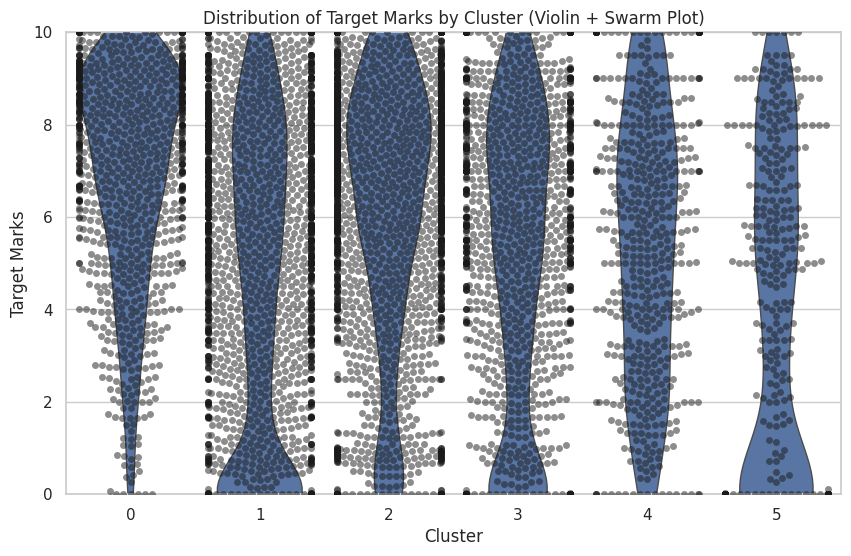

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the output data with cluster assignments and target marks
output_data_path = '/content/output_agg_simple_50.pkl'  # Update this path with your actual output file path
data = pd.read_pickle(output_data_path)

# Set seaborn style
sns.set(style="whitegrid")

# Create a violin plot to show the distribution of target marks by cluster
plt.figure(figsize=(10, 6))
sns.violinplot(x='CLUSTER', y='TARGET', data=data, inner=None, linewidth=1)
sns.swarmplot(x='CLUSTER', y='TARGET', data=data, color='k', alpha=0.5)  # Add swarmplot for individual data points
plt.xlabel('Cluster')
plt.ylabel('Target Marks')
plt.title('Distribution of Target Marks by Cluster (Violin + Swarm Plot)')
plt.ylim(0, 10)  # Set the y-axis limits to match the target marks range

plt.show()


<Figure size 1000x600 with 0 Axes>

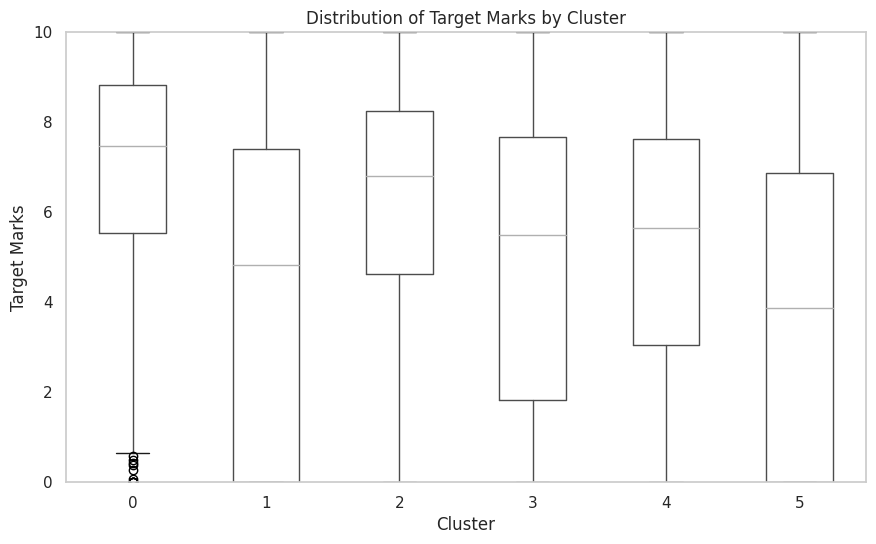

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the output data with cluster assignments and target marks
output_data_path = '/content/output_agg_simple_50.pkl'  # Update this path with your actual output file path
data = pd.read_pickle(output_data_path)

# Plotting the box plot to show distribution of target marks by cluster
plt.figure(figsize=(10, 6))
boxplot = data.boxplot(column='TARGET', by='CLUSTER', figsize=(10, 6), grid=False)
plt.xlabel('Cluster')
plt.ylabel('Target Marks')
plt.title('Distribution of Target Marks by Cluster')
plt.suptitle('')  # Remove default title generated by pandas
plt.xticks(rotation=0)
plt.ylim(0, 10)  # Set the y-axis limits to match the target marks range

plt.show()


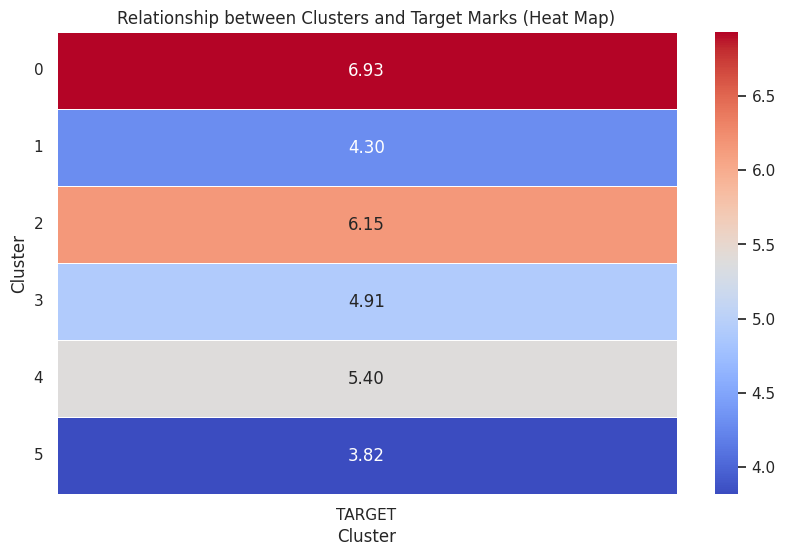

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the output data with cluster assignments and target marks
output_data_path = '/content/output_agg_simple_50.pkl'  # Update this path with your actual output file path
data = pd.read_pickle(output_data_path)

# Group the data by cluster and calculate the mean target marks for each cluster
cluster_means = data.groupby('CLUSTER')['TARGET'].mean().reset_index()

# Create a pivot table to prepare data for the heat map
pivot_table = cluster_means.pivot_table(index='CLUSTER', values='TARGET', aggfunc='mean')

# Plotting the heat map
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.xlabel('Cluster')
plt.ylabel('Cluster')
plt.title('Relationship between Clusters and Target Marks (Heat Map)')
plt.yticks(rotation=0)

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


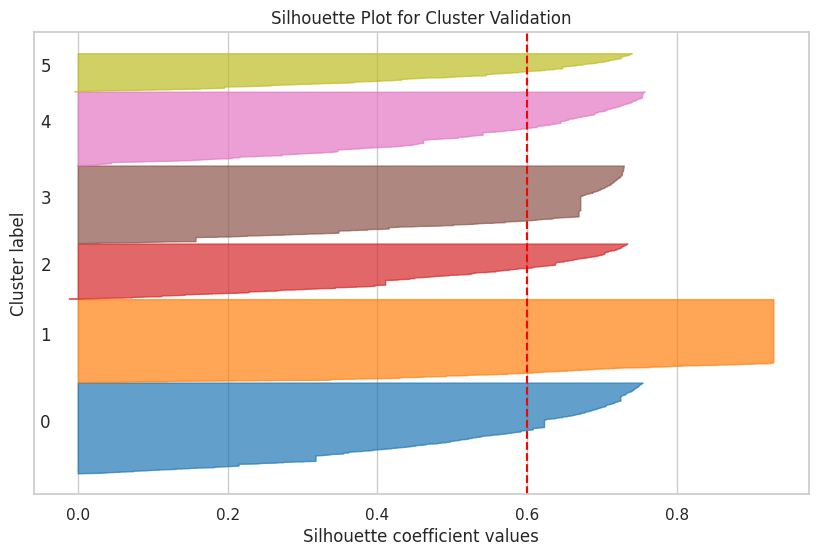

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Load the output data with cluster assignments and target marks
output_data_path = '/content/output_agg_simple_50.pkl'  # Update this path with your actual output file path
data = pd.read_pickle(output_data_path)

# Extract features (assuming 'TARGET' column is the feature of interest)
features = data[['TARGET']].values

# Fit a KMeans clustering model
num_clusters = 6  # Update this with the number of clusters used in your model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Compute silhouette scores
silhouette_avg = silhouette_score(features, cluster_labels)
sample_silhouette_values = silhouette_samples(features, cluster_labels)

# Plotting silhouette plot
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(num_clusters):
    cluster_i_values = sample_silhouette_values[cluster_labels == i]
    cluster_i_values.sort()
    size_cluster_i = cluster_i_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.tab10(i / num_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_i_values, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.yticks([])  # Hide y-axis ticks
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.title("Silhouette Plot for Cluster Validation")
plt.show()


<ipython-input-14-bafc0e6cb05d>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='CLUSTER', y='TARGET', data=data, palette='Set1')


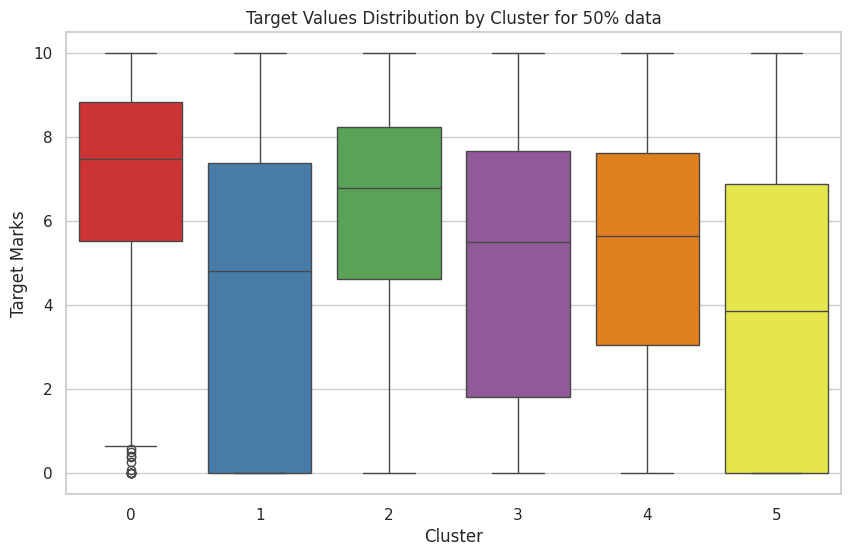

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the output data with cluster assignments and target marks
output_data_path = '/content/output_agg_simple_50.pkl'  # Update this path with your actual output file path
data = pd.read_pickle(output_data_path)

# Plotting a box plot of target values by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='CLUSTER', y='TARGET', data=data, palette='Set1')
plt.xlabel('Cluster')
plt.ylabel('Target Marks')
plt.title('Target Values Distribution by Cluster for 50% data')
plt.xticks(rotation=0)

plt.show()


<ipython-input-25-fb2c7eb9cd50>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='CLUSTER', y='TARGET', data=data, palette='Set1', showfliers=False)


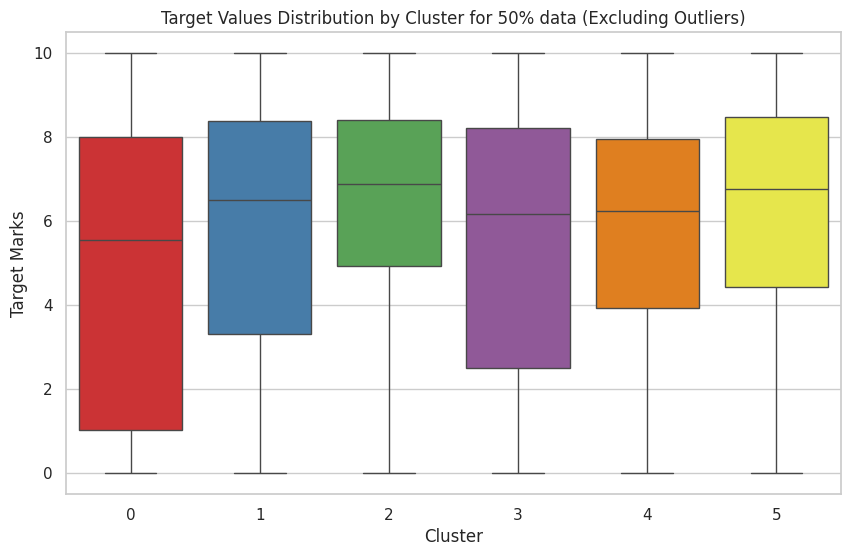

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the output data with cluster assignments and target marks
output_data_path = '/content/output_agg_simple_10.pkl'  # Update this path with your actual output file path
data = pd.read_pickle(output_data_path)

# Plotting a box plot of target values by cluster without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='CLUSTER', y='TARGET', data=data, palette='Set1', showfliers=False)
plt.xlabel('Cluster')
plt.ylabel('Target Marks')
plt.title('Target Values Distribution by Cluster for 50% data (Excluding Outliers)')
plt.xticks(rotation=0)

plt.show()


<ipython-input-15-7a0394c9ffa7>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='CLUSTER', y='TARGET', data=data, palette='Set1', inner='quartile')


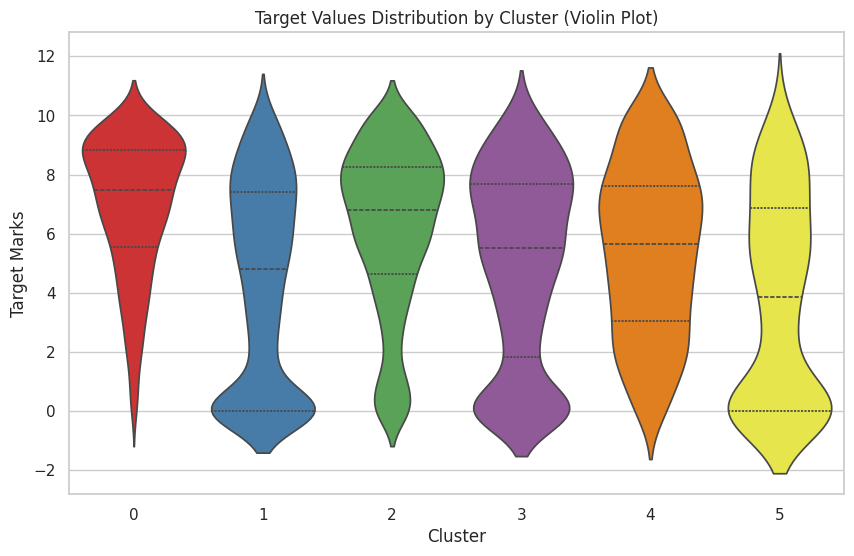

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the output data with cluster assignments and target marks
output_data_path = '/content/output_agg_simple_50.pkl'  # Update this path with your actual output file path
data = pd.read_pickle(output_data_path)

# Plotting a violin plot of target values by cluster
plt.figure(figsize=(10, 6))
sns.violinplot(x='CLUSTER', y='TARGET', data=data, palette='Set1', inner='quartile')
plt.xlabel('Cluster')
plt.ylabel('Target Marks')
plt.title('Target Values Distribution by Cluster (Violin Plot)')
plt.xticks(rotation=0)

plt.show()


<ipython-input-16-5a3c285dbee3>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='CLUSTER', y='TARGET', data=data, palette='Set1', alpha=0.7)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 32.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 66.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 63.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages

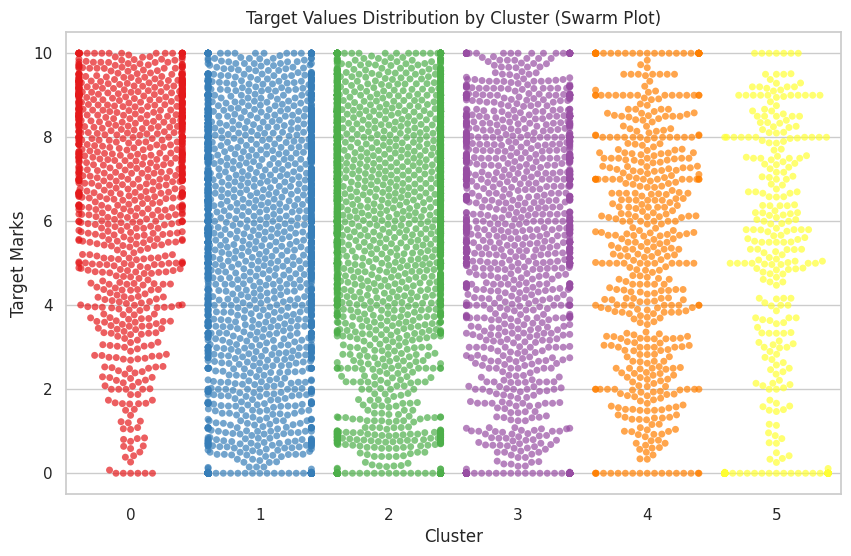

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the output data with cluster assignments and target marks
output_data_path = '/content/output_agg_simple_50.pkl'  # Update this path with your actual output file path
data = pd.read_pickle(output_data_path)

# Plotting a swarm plot of target values by cluster
plt.figure(figsize=(10, 6))
sns.swarmplot(x='CLUSTER', y='TARGET', data=data, palette='Set1', alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Target Marks')
plt.title('Target Values Distribution by Cluster (Swarm Plot)')
plt.xticks(rotation=0)

plt.show()


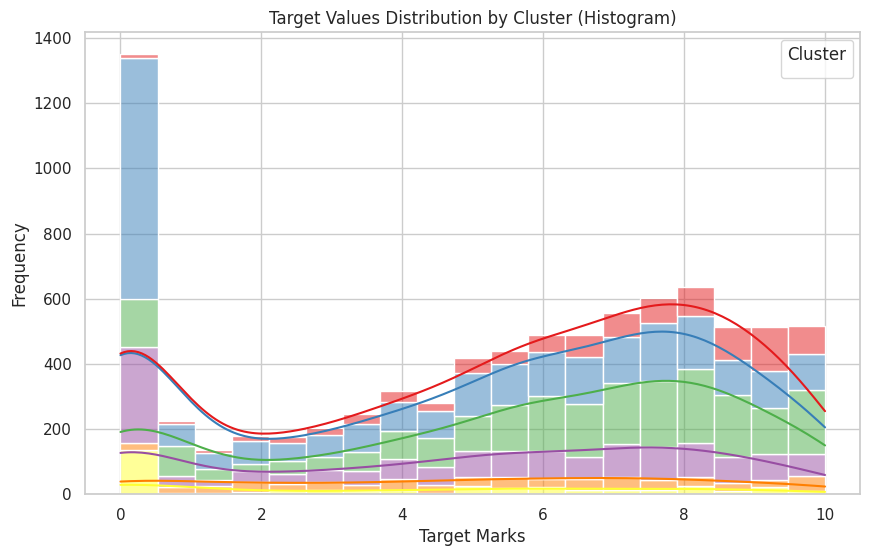

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the output data with cluster assignments and target marks
output_data_path = '/content/output_agg_simple_50.pkl'  # Update this path with your actual output file path
data = pd.read_pickle(output_data_path)

# Plotting histograms of target values by cluster
plt.figure(figsize=(10, 6))
sns.histplot(data, x='TARGET', hue='CLUSTER', multiple='stack', palette='Set1', kde=True)
plt.xlabel('Target Marks')
plt.ylabel('Frequency')
plt.title('Target Values Distribution by Cluster (Histogram)')
plt.legend(title='Cluster')

plt.show()


<Figure size 1000x600 with 0 Axes>

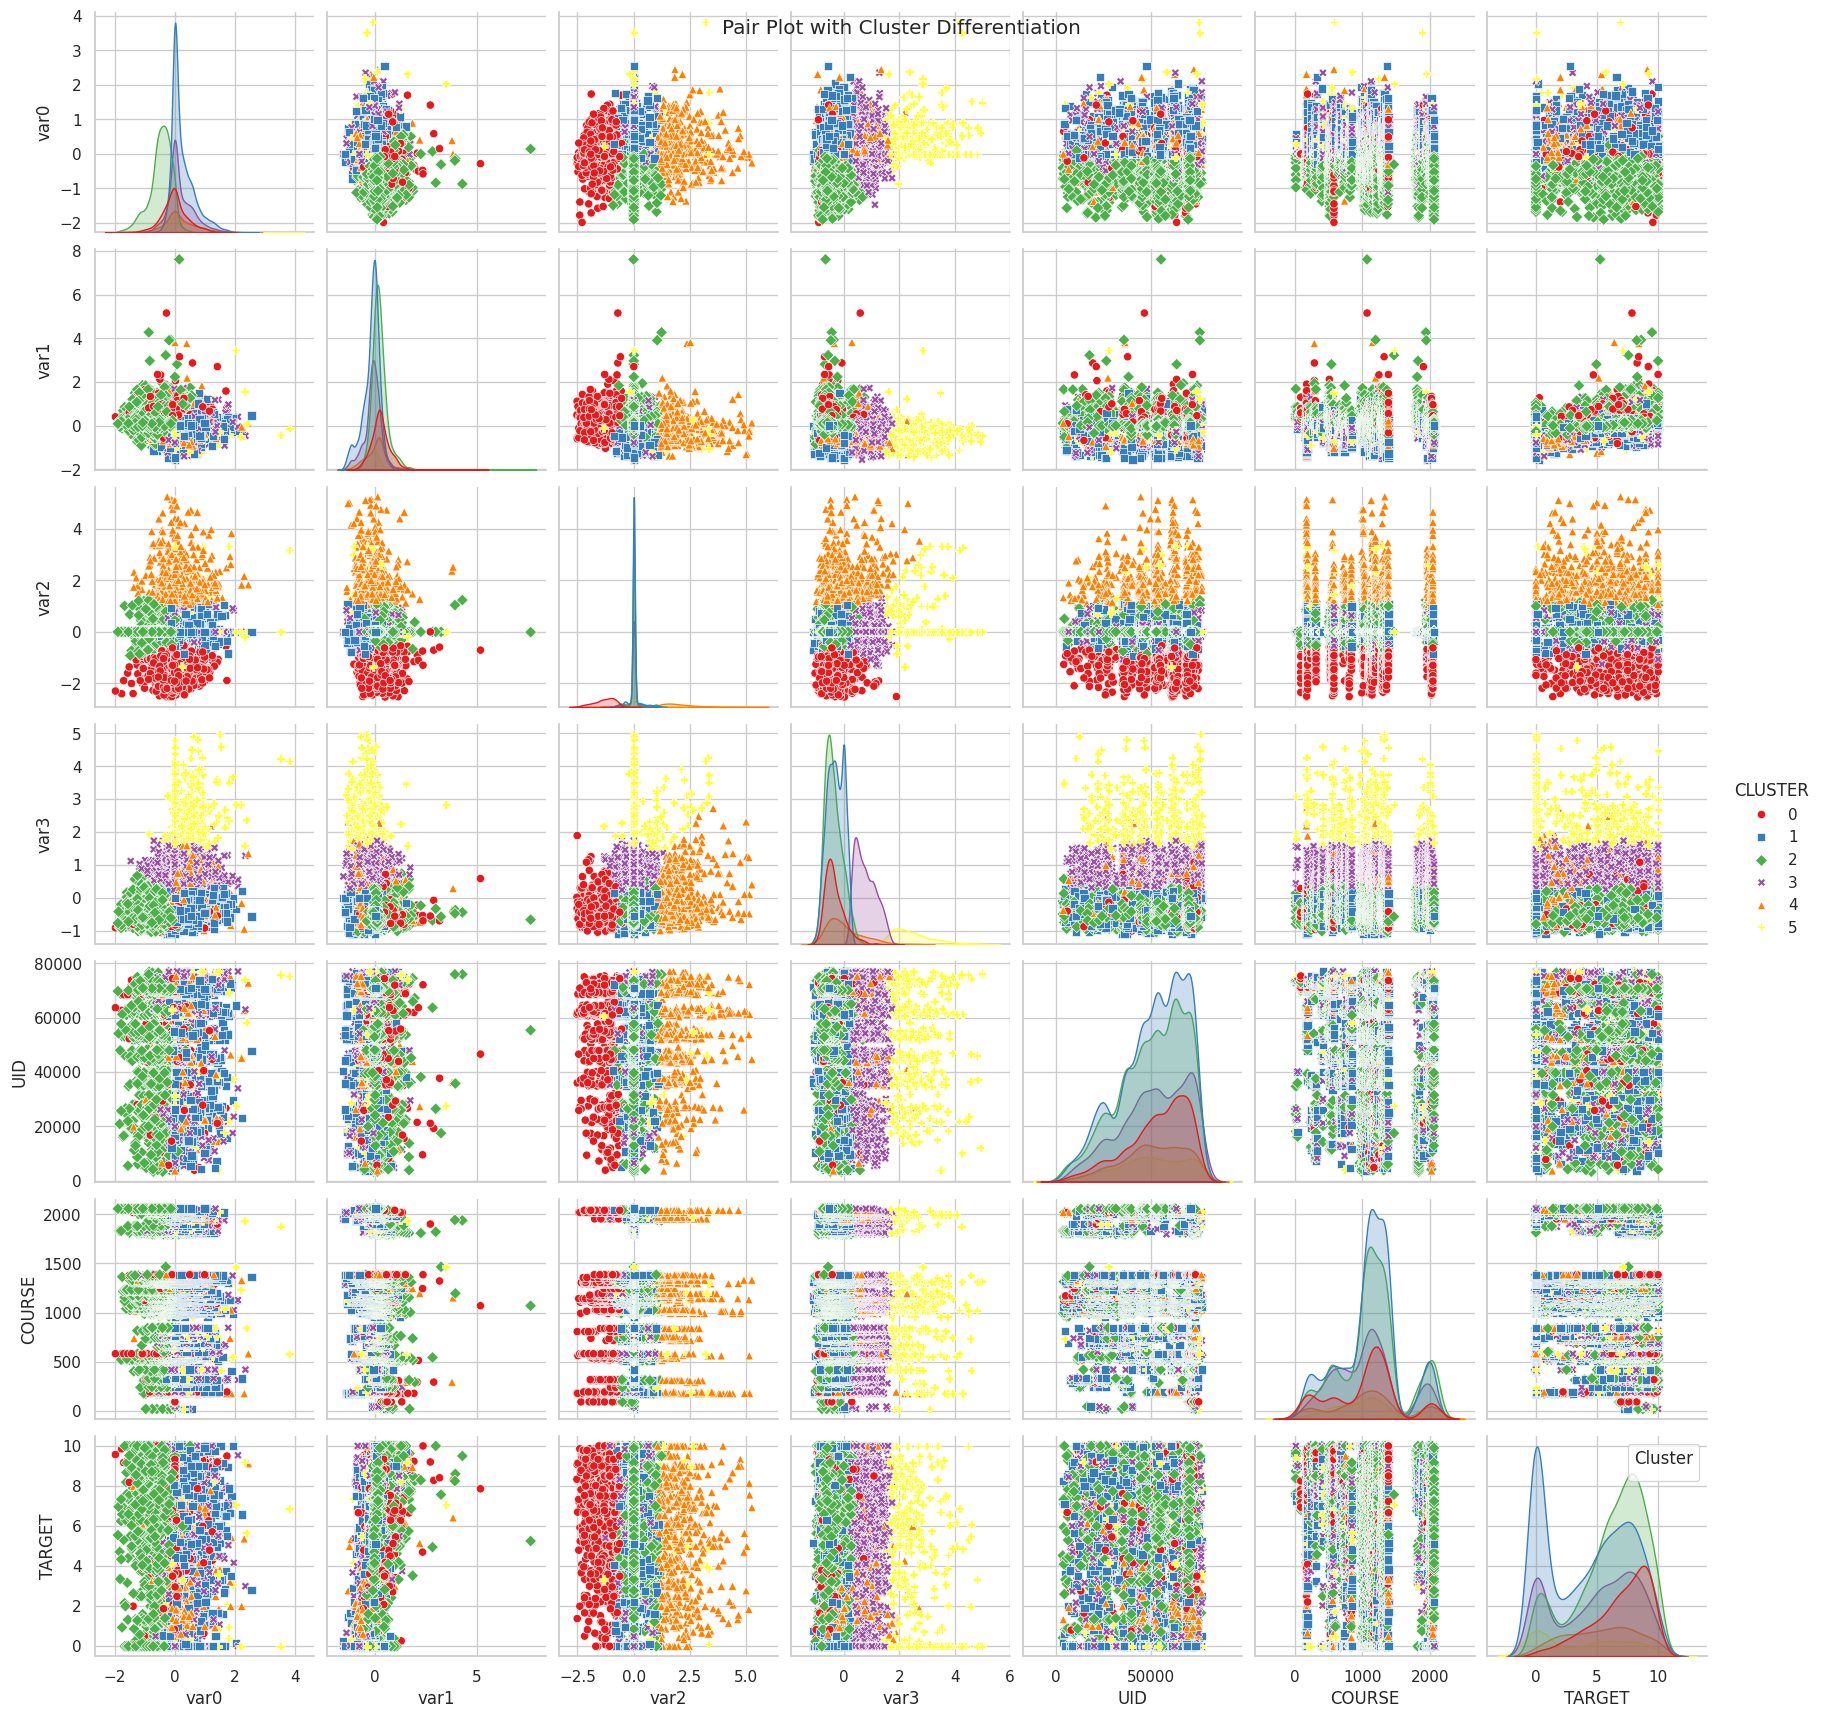

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the output data with cluster assignments and features
output_data_path = '/content/output_agg_simple_50.pkl'  # Update this path with your actual output file path
data = pd.read_pickle(output_data_path)

# Plotting a pair plot with cluster differentiation
plt.figure(figsize=(10, 6))
sns.pairplot(data=data, hue='CLUSTER', palette='Set1', markers=['o', 's', 'D', 'X', '^', 'P'])
plt.suptitle('Pair Plot with Cluster Differentiation')
plt.legend(title='Cluster')

plt.show()
